# US Airline Flight Routes and Fares 1993-2024

## Business Understanding
This analysis aims to identify the key factors that influence airline fare prices using a dataset containing detailed information on U.S. domestic flight routes from 1993 to 2024. The insights derived from this analysis will help airlines, travel agencies, and policy makers optimize pricing strategies, improve route planning, and better understand competitive dynamics in the air travel market.

## Data Understanding
The dataset provides comprehensive information on airline flight routes, fares, and passenger volumes within the United States over a span of three decades. It includes metrics such as origin and destination cities and airports, distances between airports, number of passengers, and fare details segmented by different carriers (including the largest carrier and the lowest fare carrier). This rich set of features enables an in-depth analysis of air travel trends, pricing behavior, and market share dynamics.


### Data Dictionary
- `tbl`: Table identifier
- `year`: Year of the data record
- `quarter`: Quarter of the year (1–4)
- `citymarketid_1`: Origin city market ID
- `citymarketid_2`: Destination city market ID
- `city1`: Origin city name
- `city2`: Destination city name
- `airportid_1`: Origin airport ID
- `airportid_2`: Destination airport ID
- `airport_1`: Origin airport code
- `airport_2`: Destination airport code
- `nsmiles`: Distance between airports in miles
- `passengers`: Number of passengers
- `fare`: Average fare
- `carrier_lg`: Code for the largest carrier by passengers
- `large_ms`: Market share of the largest carrier
- `fare_lg`: Average fare of the largest carrier
- `carrier_low`: Code for the lowest fare carrier
- `lf_ms`: Market share of the lowest fare carrier
- `fare_low`: Lowest fare
- `Geocoded_City1`: Geocoded coordinates for the origin city
- `Geocoded_City2`: Geocoded coordinates for the destination city
- `tbl1apk`: Unique identifier for the route

In [ ]:
# Remember to install ace_tools_open and pmdarima
# pip install ace_tools_open pmdarima in terminal and restart kernel

# Standard library imports
import os
import warnings
import time
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor


# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SHAP
import shap

# Joblib
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## Data Loading

Let's load the dataset and perform an initial exploration to understand its structure and contents.

In [ ]:
# Download dataset
filename = 'us-airline-flight-routes-and-fares-1993-2024.zip'
if not os.path.exists(filename):
  !curl -L -o us-airline-flight-routes-and-fares-1993-2024.zip \
    https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024

# Load the dataset
data = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Basic statistics
print("\nBasic statistics:")
display(data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
display(data.isnull().sum().sort_values(ascending=False))

# Check data types
print("\nData types:")
display(data.dtypes)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13.0M  100 13.0M    0     0  15.0M      0 --:--:-- --:--:-- --:--:-- 27.6M
Dataset shape: (245955, 23)

First 5 rows:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX



Basic statistics:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
count,245955,245955.000000,245955.000000,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955.000000,244415,244415.000000,244415.000000,244343,244343.000000,244343.000000,206749,206749,245955
unique,2,NaN,NaN,NaN,NaN,141,128,NaN,NaN,187,173,NaN,NaN,NaN,67,NaN,NaN,71,NaN,NaN,238,207,245955
top,Table 1a,NaN,NaN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",NaN,NaN,ORD,DCA,NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",202411541215304TYSTPA
freq,200897,NaN,NaN,NaN,NaN,26055,36913,NaN,NaN,8819,10268,NaN,NaN,NaN,58999,NaN,NaN,56027,NaN,NaN,21028,30688,1
mean,NaN,2008.524124,2.479153,31556.430201,32180.117086,NaN,NaN,12437.099986,13249.889525,NaN,NaN,1189.812319,299.476795,218.979587,NaN,0.665252,218.710963,NaN,0.450438,190.675939,NaN,NaN,NaN
std,NaN,8.703364,1.122149,1089.872880,1232.464184,NaN,NaN,1431.665257,1425.810159,NaN,NaN,703.143472,511.389486,82.372486,NaN,0.224635,84.674363,NaN,0.332669,73.577694,NaN,NaN,NaN
min,NaN,1993.000000,1.000000,30135.000000,30189.000000,NaN,NaN,10135.000000,10466.000000,NaN,NaN,109.000000,0.000000,50.000000,NaN,0.003800,50.000000,NaN,0.010000,50.000000,NaN,NaN,NaN
25%,NaN,2001.000000,1.000000,30721.000000,30994.000000,NaN,NaN,11193.000000,12197.000000,NaN,NaN,626.000000,21.000000,164.620000,NaN,0.480000,161.500000,NaN,0.158000,140.060000,NaN,NaN,NaN
50%,NaN,2008.000000,2.000000,31423.000000,32211.000000,NaN,NaN,12266.000000,13303.000000,NaN,NaN,1023.000000,113.000000,209.320000,NaN,0.652400,208.030000,NaN,0.360000,181.630000,NaN,NaN,NaN
75%,NaN,2016.000000,3.000000,32467.000000,33192.000000,NaN,NaN,13487.000000,14679.000000,NaN,NaN,1736.000000,339.000000,262.890000,NaN,0.871900,263.640000,NaN,0.750000,230.040000,NaN,NaN,NaN



Missing values per column:


,0
Geocoded_City1,39206
Geocoded_City2,39206
carrier_low,1612
lf_ms,1612
fare_low,1612
carrier_lg,1540
fare_lg,1540
large_ms,1540
city2,0
citymarketid_2,0



Data types:


,0
tbl,object
Year,int64
quarter,int64
citymarketid_1,int64
citymarketid_2,int64
city1,object
city2,object
airportid_1,int64
airportid_2,int64
airport_1,object


## Data Cleaning & Mapping Logic for Airline Dataset

This section handles critical preprocessing tasks including value imputation, feature generation, outlier removal, and mapping of airports to airlines. These transformations are essential for generating robust inputs for modeling and analysis.

---

### Section 1: Airport-to-Airline Mapping

A predefined dictionary maps major U.S. airport codes to their dominant or serving airlines (e.g., `LAX` → American, Delta, United). This mapping supports multi-airline detection from airport routes.

### Section 2: Mapping Metropolitan Cities to Airport Codes

Defines `map_metropolitan_to_airport()` function to convert broad metro area city names into representative airport codes (e.g., `New York` → `JFK`, `Los Angeles` → `LAX`). This ensures city-level route consistency in cases of ambiguous airport naming.

### Section 3: Airport Code to Airline List Function

Defines `map_airlines()` to convert an individual airport code into a list of its serving airlines using the mapping defined in Section 1.

### Section 4: `clean_airline_data()` – Core Cleaning Pipeline

This function applies a comprehensive series of cleaning operations:

- **Step 1: Missing Values**  
  Drops columns with >50% missing data, then removes rows with nulls in required columns (`fare`, `passengers`, `nsmiles`, etc.).

- **Step 2: Column Removal**  
  Drops known irrelevant columns like `'tbl'` and `'tbl1apk'`.

- **Step 3: Type Conversions**  
  Ensures numeric consistency for year, quarter, passenger counts, and distances (`nsmiles`).

- **Step 4: Feature Engineering**  
  Adds derived fields such as:
  - `fare_per_mile`
  - `passengers_per_mile`
  - `fare_per_passenger`
  - `revenue = fare × passengers`
  - `year_quarter` (for grouping and temporal sorting)
  - `period` (as `pd.PeriodIndex` for quarterly operations)

- **Step 5: Apply Metro-to-Airport Mapping**  
  Cleans ambiguous airport entries using the metro-to-airport logic defined earlier.

- **Step 6: Airline Assignment Based on Routes**  
  Enriches the dataset with:
  - `airlines_1` and `airlines_2` (serving airlines for each airport)
  - `possible_airlines` (combined and deduplicated set of all potential carriers for a given_


In [ ]:
# Mapping: airport codes to airlines

print("\n\nSection 1: Defining airport-to-airline mappings")
airport_airline_map = {
    'DFW': ['American Airlines'],
    'CLT': ['American Airlines'],
    'ORD': ['American Airlines', 'United Airlines'],
    'LAX': ['American Airlines', 'Delta Air Lines', 'United Airlines'],
    'MIA': ['American Airlines'],
    'JFK': ['American Airlines', 'Delta Air Lines'],
    'LGA': ['American Airlines', 'Delta Air Lines'],
    'PHL': ['American Airlines'],
    'PHX': ['American Airlines', 'Southwest Airlines'],
    'DCA': ['American Airlines'],
    'ATL': ['Delta Air Lines'],
    'BOS': ['Delta Air Lines'],
    'DTW': ['Delta Air Lines'],
    'MSP': ['Delta Air Lines'],
    'SLC': ['Delta Air Lines'],
    'SEA': ['Delta Air Lines'],
    'DEN': ['United Airlines', 'Southwest Airlines'],
    'IAH': ['United Airlines'],
    'EWR': ['United Airlines'],
    'SFO': ['United Airlines'],
    'IAD': ['United Airlines'],
    'BWI': ['Southwest Airlines'],
    'MDW': ['Southwest Airlines'],
    'DAL': ['Southwest Airlines'],
    'HOU': ['Southwest Airlines'],
    'LAS': ['Southwest Airlines'],
    'OAK': ['Southwest Airlines'],
    'MCO': ['Southwest Airlines'],
}


print("\n\nSection 2: Mapping metropolitan city names to major airport codes")
def map_metropolitan_to_airport(city_name):
    if "Miami" in city_name:
        return "MIA"
    elif "New York" in city_name:
        return "JFK"  # or LGA
    elif "Boston" in city_name:
        return "BOS"
    elif "San Francisco" in city_name:
        return "SFO"
    elif "Los Angeles" in city_name:
        return "LAX"
    elif "Norfolk" in city_name:
        return "DCA"
    elif "Cleveland" in city_name:
        return "ORD"
    elif "Washington" in city_name:
        return "DCA"
    elif "Atlanta" in city_name:
        return "ATL"
    elif "Tampa" in city_name:
        return "MCO"
    else:
        return None

print("\n\nSection 3: Mapping airport codes to airline lists")
def map_airlines(airport_code):
    return airport_airline_map.get(airport_code, [])


print("\n\nSection 4: Cleaning airline dataset")
def clean_airline_data(df):
    """Clean and preprocess the airline fare dataset for predictive modeling."""

    df_clean = df.copy()

    print("\nStep 1: Handling missing values")
    missing_percent = df_clean.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns with >50% missing values: {cols_to_drop}")

    initial_rows = df_clean.shape[0]
    required_cols = ['fare', 'passengers', 'nsmiles', 'quarter', 'Year']
    df_clean = df_clean.dropna(subset=required_cols)
    df_clean = df_clean.drop_duplicates()

    cols_to_remove = ['tbl', 'tbl1apk']
    for col in cols_to_remove:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
            print(f"Dropped column: {col}")

    dropped_rows = initial_rows - df_clean.shape[0]
    print(f"\nDropped {dropped_rows} rows with missing values")
    print(f"Shape after dropping NaN values: {df_clean.shape}")

    print("\nStep 2: Handling outliers - defining function")
    def remove_outliers_by_year(df, column, group_col='Year'):
        def iqr_filter(sub_df):
            if len(sub_df) < 100:
                return sub_df
            Q1 = sub_df[column].quantile(0.25)
            Q3 = sub_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return sub_df[(sub_df[column] >= lower) & (sub_df[column] <= upper)]
        return df.groupby(group_col, group_keys=False).apply(iqr_filter)

    print("\nStep 3: Converting data types")
    if 'Year' in df_clean.columns:
        df_clean['Year'] = df_clean['Year'].astype(int)
    if 'quarter' in df_clean.columns:
        df_clean['quarter'] = df_clean['quarter'].astype(int)
    if 'passengers' in df_clean.columns:
        df_clean['passengers'] = df_clean['passengers'].astype(int)
    if 'nsmiles' in df_clean.columns:
        df_clean['nsmiles'] = df_clean['nsmiles'].astype(float)

    print("\nStep 4: Creating new features")
    if 'fare' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['fare_per_mile'] = df_clean['fare'] / (df_clean['nsmiles'] + 1e-5)
    if 'passengers' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['passengers_per_mile'] = df_clean['passengers'] / (df_clean['nsmiles'] + 1e-5)
    if 'passengers' in df_clean.columns:
        df_clean['fare_per_passenger'] = df_clean['fare_per_mile'] / (df_clean['passengers_per_mile'] + 1e-5)

    df_clean['revenue'] = df_clean['passengers'] * df_clean['fare']
    df_clean['year_quarter'] = df_clean['Year'].astype(str) + 'Q' + df_clean['quarter'].astype(str)
    df_clean['year_num'] = df_clean['Year'].astype(int)
    df_clean['quarter_num'] = df_clean['quarter'].astype(int)

    ordered_quarters = (
        df_clean[['year_quarter', 'year_num', 'quarter_num']]
        .drop_duplicates()
        .sort_values(by=['year_num', 'quarter_num'])['year_quarter']
        .tolist()
    )
    df_clean['year_quarter'] = pd.Categorical(df_clean['year_quarter'], categories=ordered_quarters, ordered=True)

    if 'period' not in df_clean.columns:
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')

    print("\nStep 5: Mapping metropolitan cities to airports")
    if 'airport_1' in df_clean.columns and 'city1' in df_clean.columns:
        df_clean['airport_1'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city1']) if 'Metropolitan' in str(row['city1']) else row['airport_1'],
            axis=1
        )
    if 'airport_2' in df_clean.columns and 'city2' in df_clean.columns:
        df_clean['airport_2'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city2']) if 'Metropolitan' in str(row['city2']) else row['airport_2'],
            axis=1
        )

    print("\nStep 6: Mapping airlines from airport codes")
    if 'airport_1' in df_clean.columns:
        df_clean['airlines_1'] = df_clean['airport_1'].apply(map_airlines)
    if 'airport_2' in df_clean.columns:
        df_clean['airlines_2'] = df_clean['airport_2'].apply(map_airlines)

    df_clean['possible_airlines'] = [
        list(set(a1 + a2)) for a1, a2 in zip(df_clean['airlines_1'], df_clean['airlines_2'])
    ]

    print("\nStep 7: Removing outliers from selected numeric columns")
    numeric_cols = [col for col in ['fare', 'passengers', 'nsmiles', 'fare_per_mile', 'passengers_per_mile', 'revenue'] if col in df_clean.columns]
    for column in numeric_cols:
        if column not in ['fare', 'revenue', 'passengers', 'Year', 'year_quarter', 'year_num']:
            df_clean = remove_outliers_by_year(df_clean, column)

    print("Shape after removing outliers:", df_clean.shape)
    return df_clean


print("\n\nSection 5: Applying cleaning function to raw data")
df_clean = clean_airline_data(data)

print("\n\nSection: Previewing cleaned data and extracting metropolitan city info")
print("\nSample of cleaned dataset:")
display(df_clean[['airport_1', 'airport_2', 'year_quarter', 'passengers', 'fare', 'revenue']].head())

if 'city1' in df_clean.columns:
    metropolitan_city1 = df_clean.loc[df_clean['city1'].str.contains('Metropolitan', case=False, na=False), 'city1'].unique()
else:
    metropolitan_city1 = []

if 'city2' in df_clean.columns:
    metropolitan_city2 = df_clean.loc[df_clean['city2'].str.contains('Metropolitan', case=False, na=False), 'city2'].unique()
else:
    metropolitan_city2 = []

metropolitan_cities_set = set(metropolitan_city1).union(set(metropolitan_city2))

print("\nUnique set of Metropolitan cities:")
print(metropolitan_cities_set, len(metropolitan_cities_set))

print("\nCleaned dataset info:")
df_clean.info()
display(df_clean.head())




Section 1: Defining airport-to-airline mappings


Section 2: Mapping metropolitan city names to major airport codes


Section 3: Mapping airport codes to airline lists


Section 4: Cleaning airline dataset


Section 5: Applying cleaning function to raw data

Step 1: Handling missing values
Dropped columns with >50% missing values: []
Dropped column: tbl
Dropped column: tbl1apk

Dropped 0 rows with missing values
Shape after dropping NaN values: (245955, 21)

Step 2: Handling outliers - defining function

Step 3: Converting data types

Step 4: Creating new features

Step 5: Mapping metropolitan cities to airports

Step 6: Mapping airlines from airport codes

Step 7: Removing outliers from selected numeric columns
Shape after removing outliers: (204203, 32)


Section: Previewing cleaned data and extracting metropolitan city info

Sample of cleaned dataset:


,airport_1,airport_2,year_quarter,passengers,fare,revenue
5923,HSV,DCA,1993Q4,21,242.76,5097.96
5930,IAH,SFO,1993Q1,51,272.66,13905.66
5961,BHM,LAX,1993Q1,2,290.64,581.28
5969,JFK,RIC,1993Q1,4,173.52,694.08
5983,SAN,DCA,1993Q1,266,290.94,77390.04



Unique set of Metropolitan cities:
{'Washington, DC (Metropolitan Area)', 'Atlanta, GA (Metropolitan Area)', 'Los Angeles, CA (Metropolitan Area)', 'Tampa, FL (Metropolitan Area)', 'San Francisco, CA (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'New York City, NY (Metropolitan Area)', 'Miami, FL (Metropolitan Area)', 'Boston, MA (Metropolitan Area)', 'Norfolk, VA (Metropolitan Area)'} 10

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 204203 entries, 5923 to 245954
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype        
---  ------               --------------   -----        
 0   Year                 204203 non-null  int64        
 1   quarter              204203 non-null  int64        
 2   citymarketid_1       204203 non-null  int64        
 3   citymarketid_2       204203 non-null  int64        
 4   city1                204203 non-null  object       
 5   city2                204203 non-null  object       
 6   a

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,fare_per_mile,passengers_per_mile,fare_per_passenger,revenue,year_quarter,year_num,quarter_num,period,airlines_1,airlines_2,possible_airlines
5923,1993,4,30255,30852,"Huntsville, AL","Washington, DC (Metropolitan Area)",12217,12264,HSV,DCA,640.0,21,242.76,DL,0.48,275.50,UA,0.25,197.69,"Huntsville, AL\n(34.729538, -86.585283)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.379312,0.032812,11.556478,5097.96,1993Q4,1993,4,1993Q4,[],[American Airlines],[American Airlines]
5930,1993,1,31453,32457,"Houston, TX","San Francisco, CA (Metropolitan Area)",12266,13796,IAH,SFO,1657.0,51,272.66,HP,0.64,230.26,HP,0.64,230.26,"Houston, TX\n(29.760803, -95.369506)","San Francisco, CA (Metropolitan Area)\n(37.78008, -122.420168)",0.164550,0.030779,5.344538,13905.66,1993Q1,1993,1,1993Q1,[United Airlines],[United Airlines],[United Airlines]
5961,1993,1,30599,32575,"Birmingham, AL","Los Angeles, CA (Metropolitan Area)",10599,12954,BHM,LAX,1815.0,2,290.64,AA,1.00,290.64,AA,1.00,290.64,"Birmingham, AL\n(33.522859, -86.807705)","Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)",0.160132,0.001102,144.013081,581.28,1993Q1,1993,1,1993Q1,[],"[American Airlines, Delta Air Lines, United Airlines]","[Delta Air Lines, American Airlines, United Airlines]"
5969,1993,1,31703,34524,"New York City, NY (Metropolitan Area)","Richmond, VA",15070,14524,JFK,RIC,325.0,4,173.52,US,0.81,178.83,US,0.81,178.83,"New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)","Richmond, VA\n(37.540759, -77.433932)",0.533908,0.012308,43.344782,694.08,1993Q1,1993,1,1993Q1,"[American Airlines, Delta Air Lines]",[],"[Delta Air Lines, American Airlines]"
5983,1993,1,33570,30852,"San Diego, CA","Washington, DC (Metropolitan Area)",14679,11278,SAN,DCA,2295.0,266,290.94,AA,0.26,343.23,NW,0.24,209.78,"San Diego, CA\n(32.71576, -117.163817)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.126771,0.115904,1.093665,77390.04,1993Q1,1993,1,1993Q1,[],[American Airlines],[American Airlines]


## Exploratory Data Analysis (EDA) on Airline Dataset

This section performs visual and statistical exploration of the airline dataset to identify trends, anomalies, and relationships among variables. The goal is to better understand the data prior to modeling and forecasting.

---

### 1. Distribution of Numerical Columns by Year

Plots the yearly average trends of selected numeric features (e.g., `passengers`, `fare`, `revenue`, etc.), allowing insight into long-term patterns or seasonal effects.

### 2. Distribution of Categorical Columns

Iterates over all object-type categorical columns and plots their frequency using bar charts. Columns with fewer than 60 unique values are plotted; high-cardinality columns are skipped for readability.

### 3. Frequency of Values in `possible_airlines`

Unpacks lists of airlines from the `possible_airlines` column and plots their overall frequency to understand which airlines appear most often.

### 4. Correlation Heatmap for Numerical Variables

Generates a heatmap of correlation coefficients between all numeric features to uncover multicollinearity and feature relationships (e.g., between `passengers`, `fare`, and `revenue`).

### 5. Passenger Volume Over Time by Top 5 Origin Airports

Aggregates passenger volume by year and plots line charts for the top 5 busiest origin airports, highlighting key contributors to traffic trends.

### 6. Average Fare Over Time by Top 5 Carriers

Visualizes how average fares have changed over time for the top 5 carriers. This helps in identifying pricing strategies or market shifts.

### 7. Heatmap of Top 25 Origin-Destination Pairs

Uses a 2D heatmap to show the flight count between top 25 airport pairs, offering a snapshot of the most heavily trafficked airline routes.

### 8. Quarterly Revenue Trend

Plots the overall revenue per quarter across all years to highlight macroeconomic impacts or seasonal revenue fluctuations in the airline industry.



Section 1: Plotting numerical column distributions by year
Plotting time trends for numerical columns grouped by 'Year'...


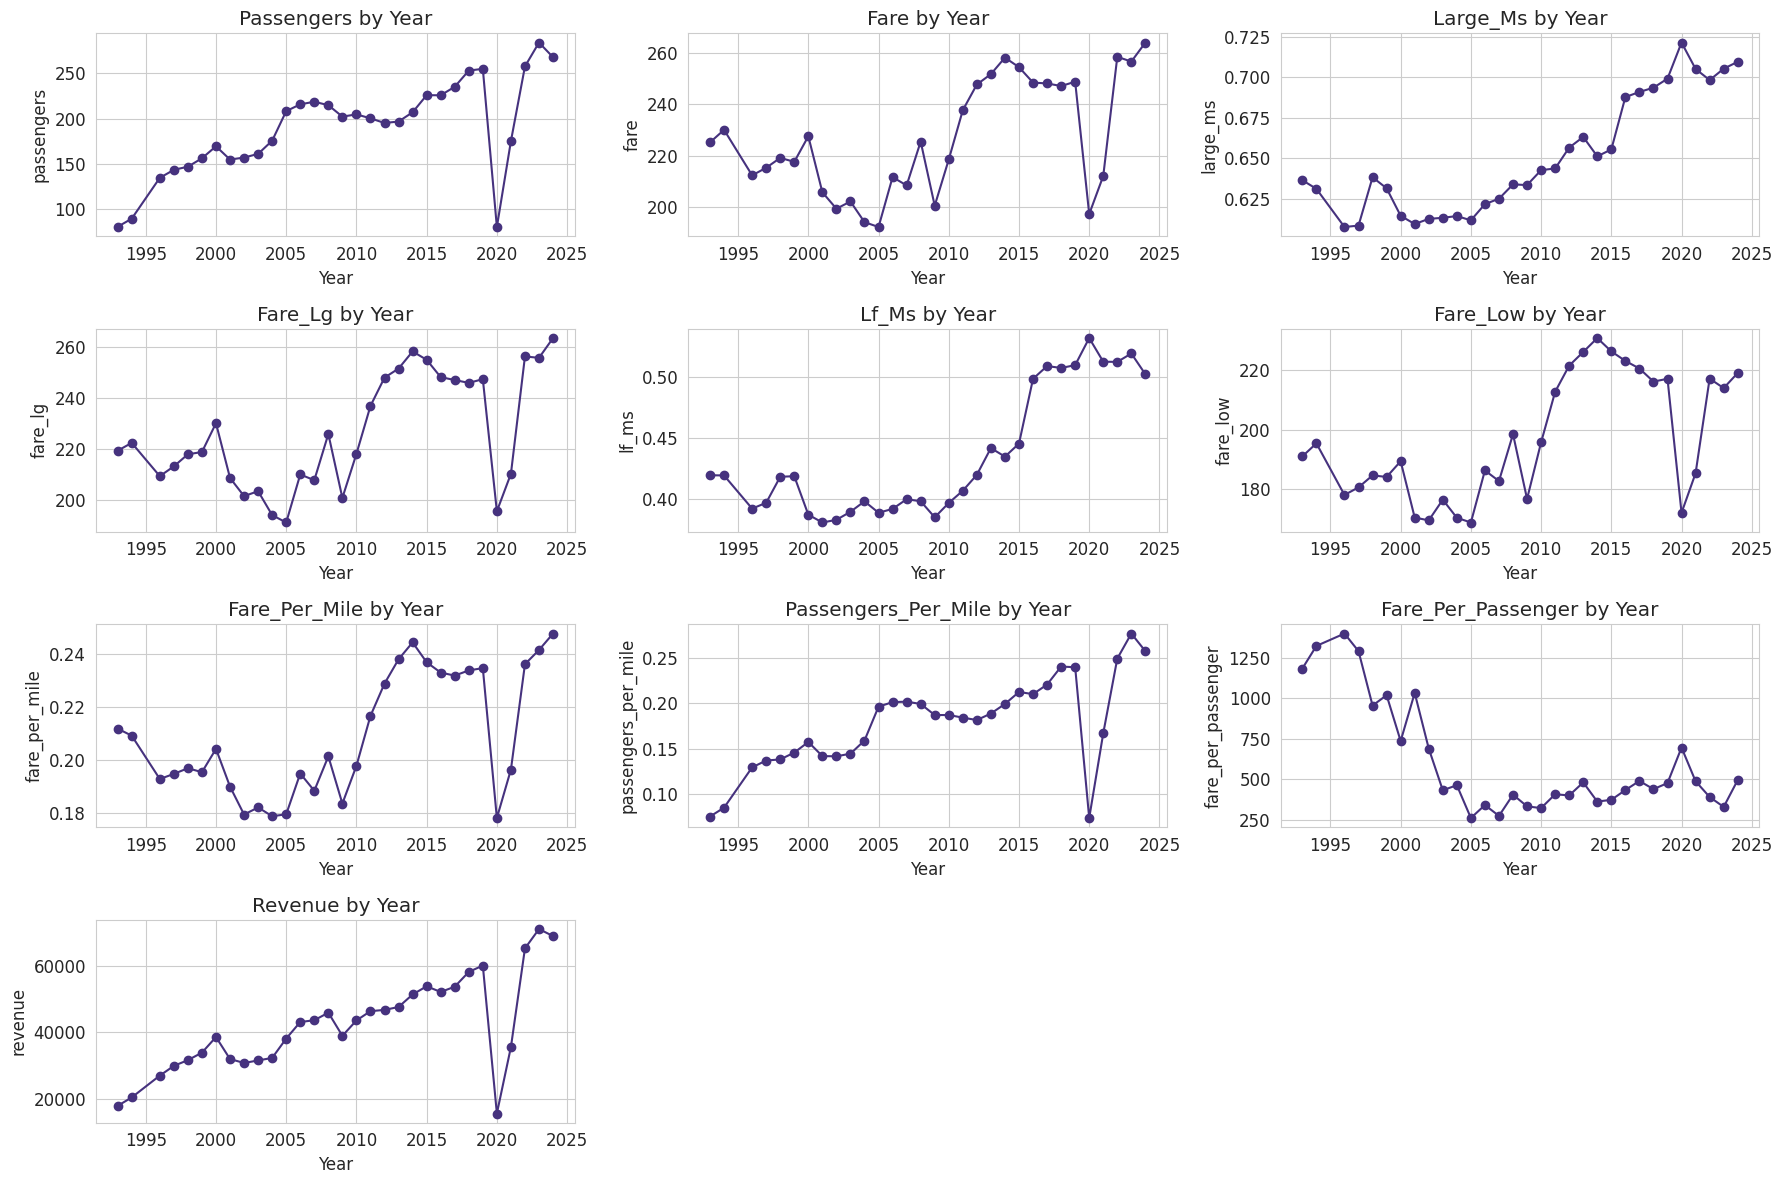



Section 2: Plotting distribution of categorical columns
Skipped 'city1' due to high cardinality: 140 unique values
Skipped 'city2' due to high cardinality: 126 unique values
Skipped 'airport_1' due to high cardinality: 159 unique values
Skipped 'airport_2' due to high cardinality: 144 unique values
Skipped 'carrier_lg' due to high cardinality: 62 unique values
Skipped 'carrier_low' due to high cardinality: 63 unique values
Skipped 'Geocoded_City1' due to high cardinality: 233 unique values
Skipped 'Geocoded_City2' due to high cardinality: 203 unique values


Section 3: Plotting frequency of values in 'possible_airlines'


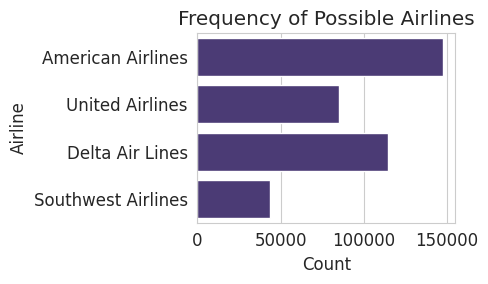



Section 4: Plotting correlation heatmap for numerical variables


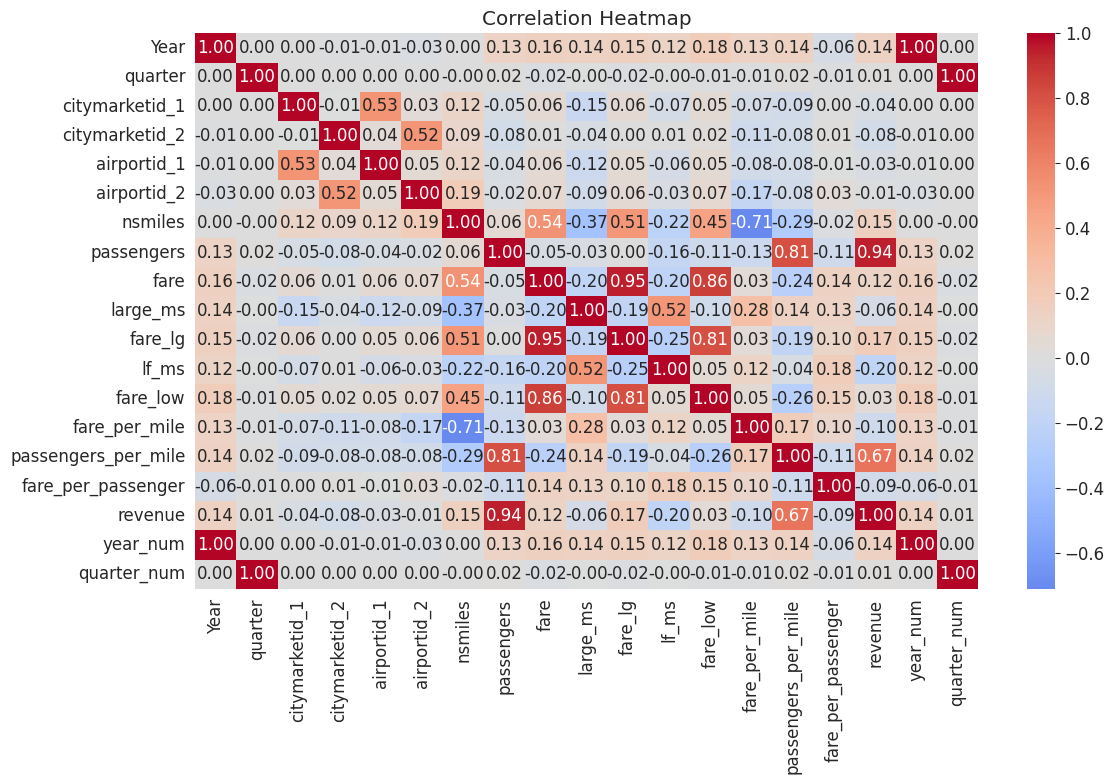



Section 5: Plotting passenger volume over time by top 5 origin airports


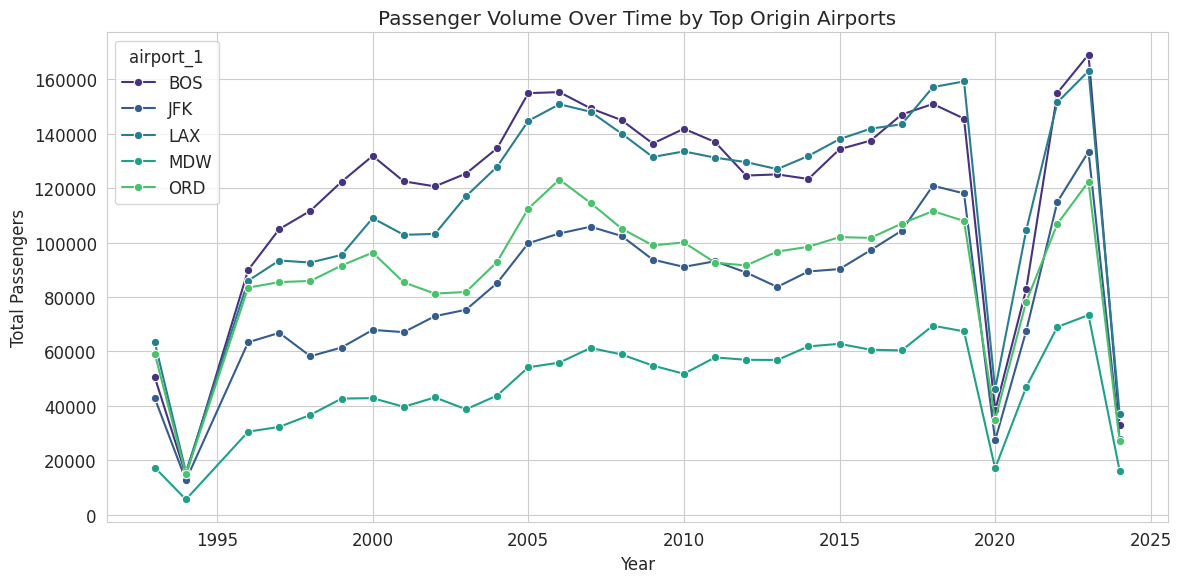



Section 6: Plotting average fare over time by top carriers


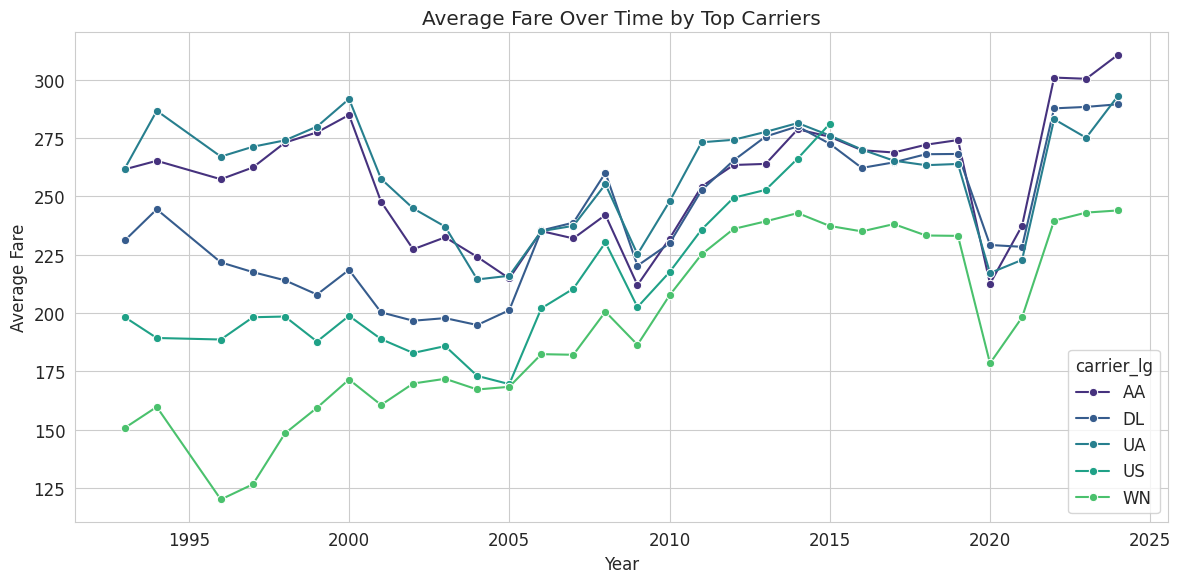



Section 7: Plotting heatmap of top 25 origin-destination pairs by flight count


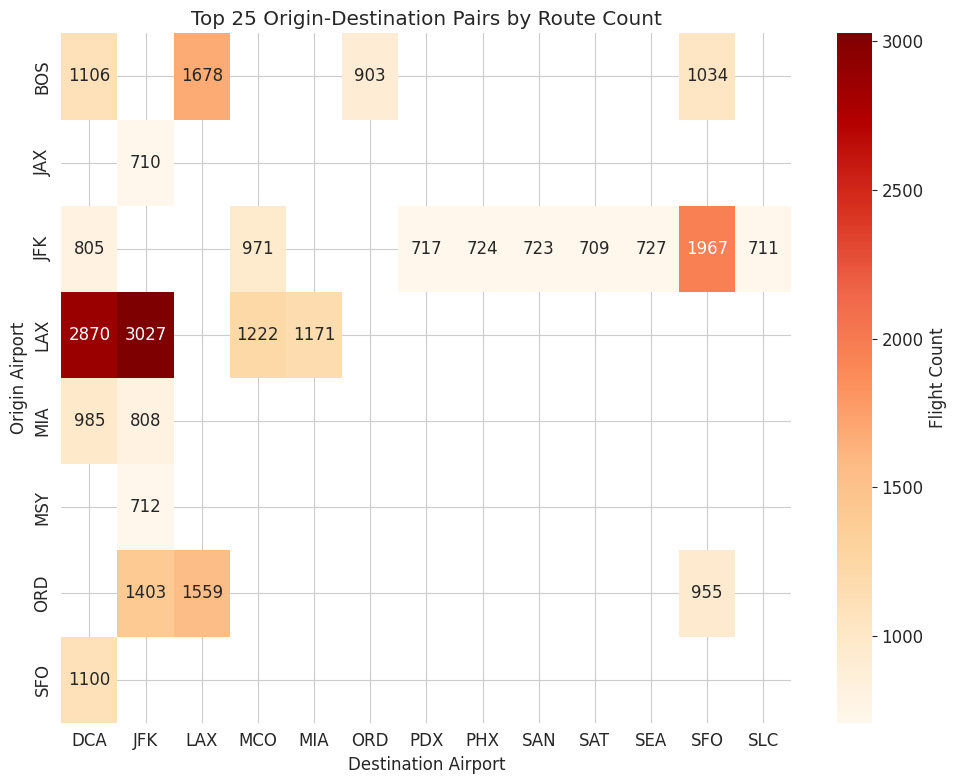



Section 8: Plotting quarterly revenue trend


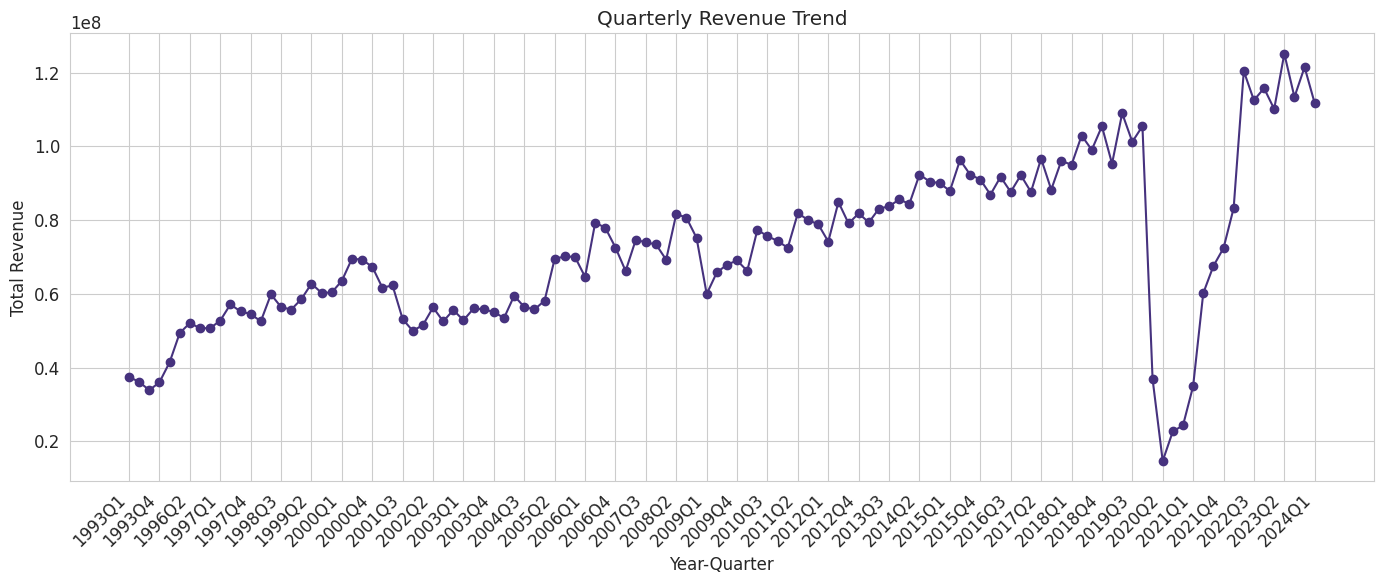

In [ ]:
def plot_distributions_by_year(df, columns, year_col='Year', ncols=3, figsize=(18, 12)):
    """Plot distribution of numerical columns grouped by year."""
    print(f"Plotting time trends for numerical columns grouped by '{year_col}'...")

    if year_col not in df.columns:
        raise ValueError(f"'{year_col}' column not found in DataFrame.")

    df = df.copy()

    # Ensure year is integer
    if not np.issubdtype(df[year_col].dtype, np.integer):
        df[year_col] = df[year_col].astype(int)

    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    i = 0
    for i, col in enumerate(columns):
        if col in df.columns and col.lower() not in ['year', 'quarter']:
            grouped = df.groupby(year_col)[col].mean().dropna()
            if len(grouped) > 1:
                axes[i].plot(grouped.index, grouped.values, marker='o')
                axes[i].set_title(f'{col.title()} by Year')
                axes[i].set_xlabel('Year')
                axes[i].set_ylabel(col)
                axes[i].grid(True)
            else:
                axes[i].text(0.5, 0.5, 'Not enough data to plot', ha='center', va='center')
                axes[i].set_title(f'{col.title()} by Year')
                axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 1. Plot numerical feature trends by year
# ---------------------------------------
print("\n\nSection 1: Plotting numerical column distributions by year")
columns_to_plot = [
    'passengers', 'fare', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low',
    'fare_per_mile', 'passengers_per_mile', 'fare_per_passenger', 'revenue'
]
plot_distributions_by_year(df_clean, columns_to_plot)

# ---------------------------------------
# 2. Plot distribution of categorical columns
# ---------------------------------------
print("\n\nSection 2: Plotting distribution of categorical columns")
cat_cols = [
    col for col in df_clean.select_dtypes(include=['object']).columns
    if not df_clean[col].apply(lambda x: isinstance(x, list)).any()
]

for col in cat_cols:
    unique_vals = df_clean[col].nunique()
    if unique_vals < 60:
        print(f"Plotting categorical distribution: {col} ({unique_vals} categories)")
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_clean,
                      order=df_clean[col].value_counts().index)
        plt.title(f'Distribution of {col} ({unique_vals} categories)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipped '{col}' due to high cardinality: {unique_vals} unique values")

# ---------------------------------------
# 3. Plot frequency of possible airlines
# ---------------------------------------
print("\n\nSection 3: Plotting frequency of values in 'possible_airlines'")
flattened = list(chain.from_iterable(df_clean['possible_airlines']))
airline_counts = Counter(flattened)
plt.figure(figsize=(5, 3))
sns.barplot(x=list(airline_counts.values()), y=list(airline_counts.keys()))
plt.title('Frequency of Possible Airlines')
plt.xlabel('Count')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 4. Correlation heatmap
# ---------------------------------------
print("\n\nSection 4: Plotting correlation heatmap for numerical variables")
plt.figure(figsize=(12, 8))
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 5. Passenger volume over time by top 5 origin airports
# ---------------------------------------
print("\n\nSection 5: Plotting passenger volume over time by top 5 origin airports")
top_airports = df_clean['airport_1'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['airport_1'].isin(top_airports)]

grouped = (
    filtered.groupby(['Year', 'airport_1'])['passengers']
    .sum()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='passengers', hue='airport_1', marker='o')
plt.title('Passenger Volume Over Time by Top Origin Airports')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 6. Average fare by top carriers
# ---------------------------------------
print("\n\nSection 6: Plotting average fare over time by top carriers")
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['carrier_lg'].isin(top_carriers)]

grouped = (
    filtered.groupby(['Year', 'carrier_lg'])['fare']
    .mean()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='fare', hue='carrier_lg', marker='o')
plt.title('Average Fare Over Time by Top Carriers')
plt.xlabel('Year')
plt.ylabel('Average Fare')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 7. Heatmap of top origin-destination pairs
# ---------------------------------------
print("\n\nSection 7: Plotting heatmap of top 25 origin-destination pairs by flight count")
od_counts = df_clean.groupby(['airport_1', 'airport_2']).size().reset_index(name='count')
top_pairs = od_counts.sort_values('count', ascending=False).head(25)

pivot = top_pairs.pivot(index='airport_1', columns='airport_2', values='count')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='OrRd', cbar_kws={'label': 'Flight Count'})
plt.title('Top 25 Origin-Destination Pairs by Route Count')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 8. Quarterly revenue trend
# ---------------------------------------
print("\n\nSection 8: Plotting quarterly revenue trend")
quarterly_revenue = (
    df_clean.groupby('period')['revenue']
    .sum()
    .reset_index()
    .sort_values('period')
)

plt.figure(figsize=(14, 6))
plt.plot(
        quarterly_revenue['period'].astype(str),
         quarterly_revenue['revenue'],
         marker='o'
)
tick_positions = range(0, len(quarterly_revenue), 3)
plt.xticks(
    tick_positions,
    quarterly_revenue['period'].astype(str).iloc[tick_positions],
    rotation=45,
    ha='right'
)

plt.title('Quarterly Revenue Trend')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


Profit Margin vs Revenue by Distance Bucket (2018–2024):


,distance_bucket,revenue,profit,profit_margin
0,0-500mi,54094.331883,42081.722733,0.787653
1,501-1000mi,71120.035667,41804.389480,0.590501
2,1001-1500mi,78613.771320,34181.210997,0.425519
3,1501-2000mi,78960.918641,26144.220223,0.312403
4,2001-2500mi,73026.937312,17418.181316,0.204803
5,2501-3000mi,111432.534484,29588.396478,0.105513


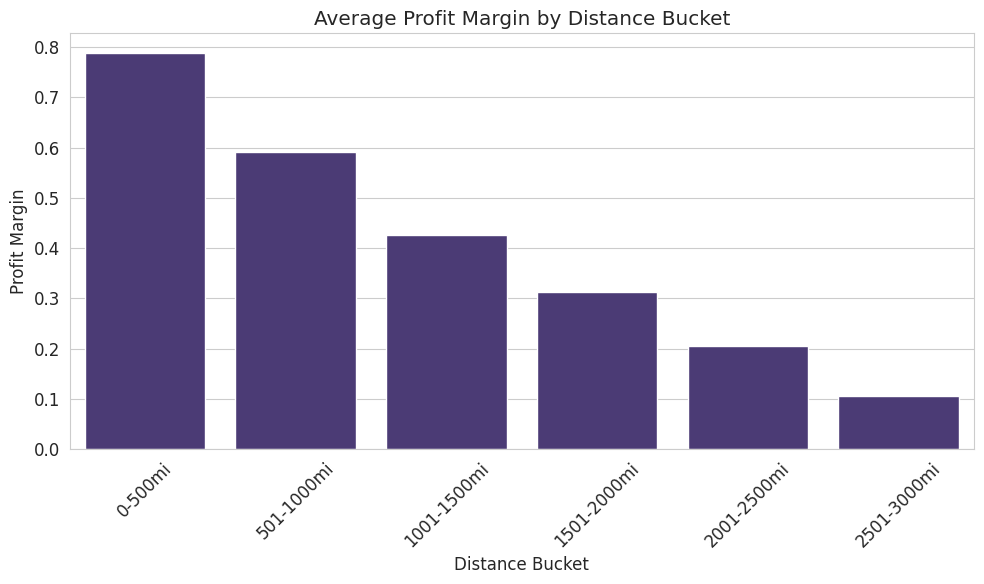

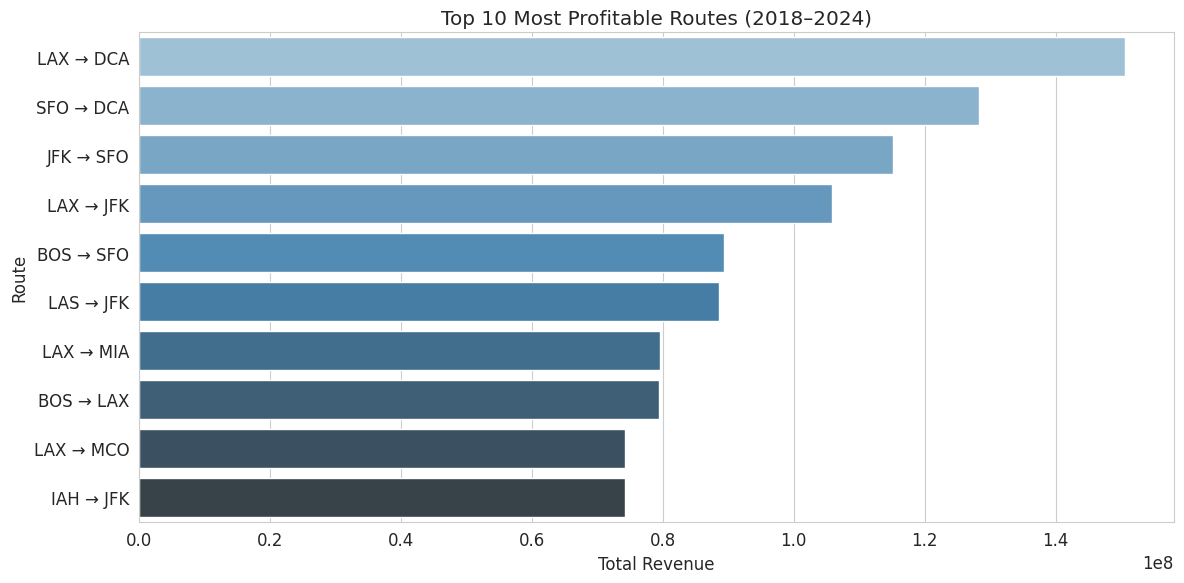

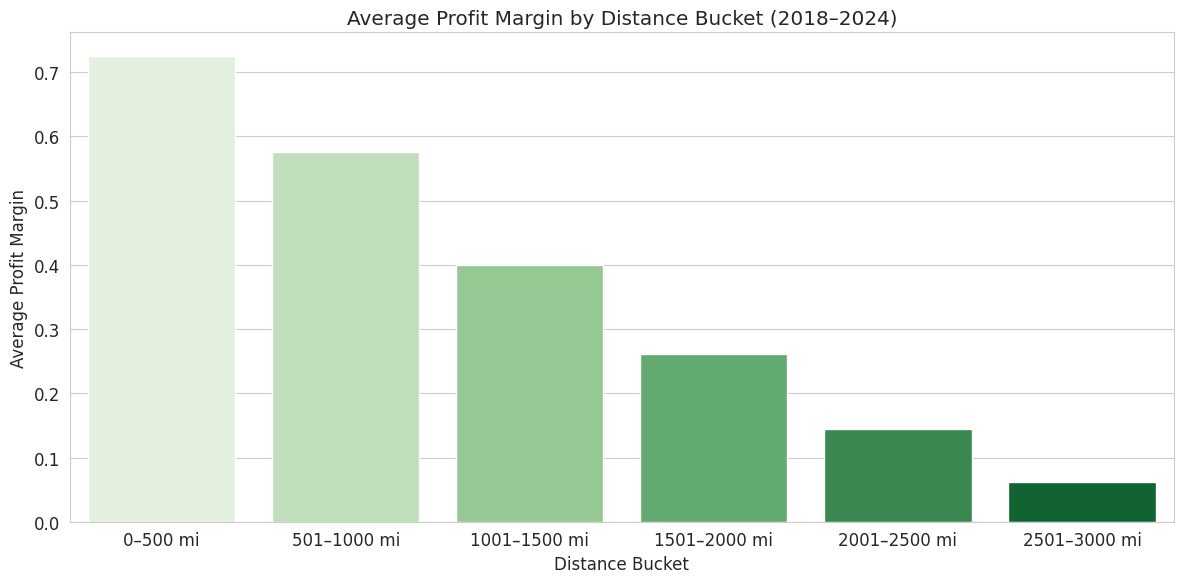

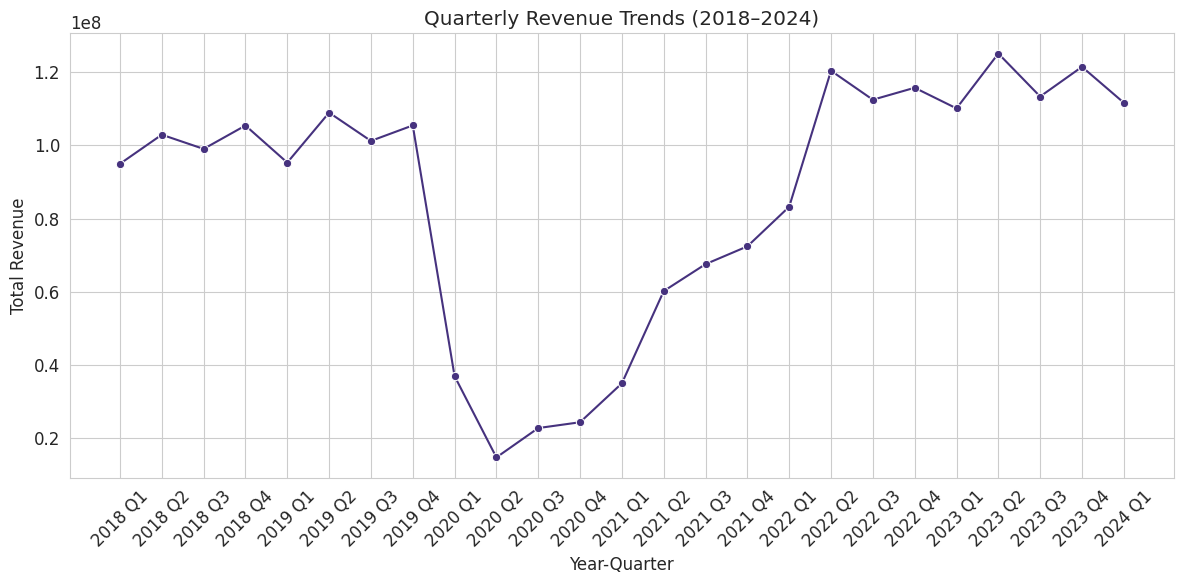

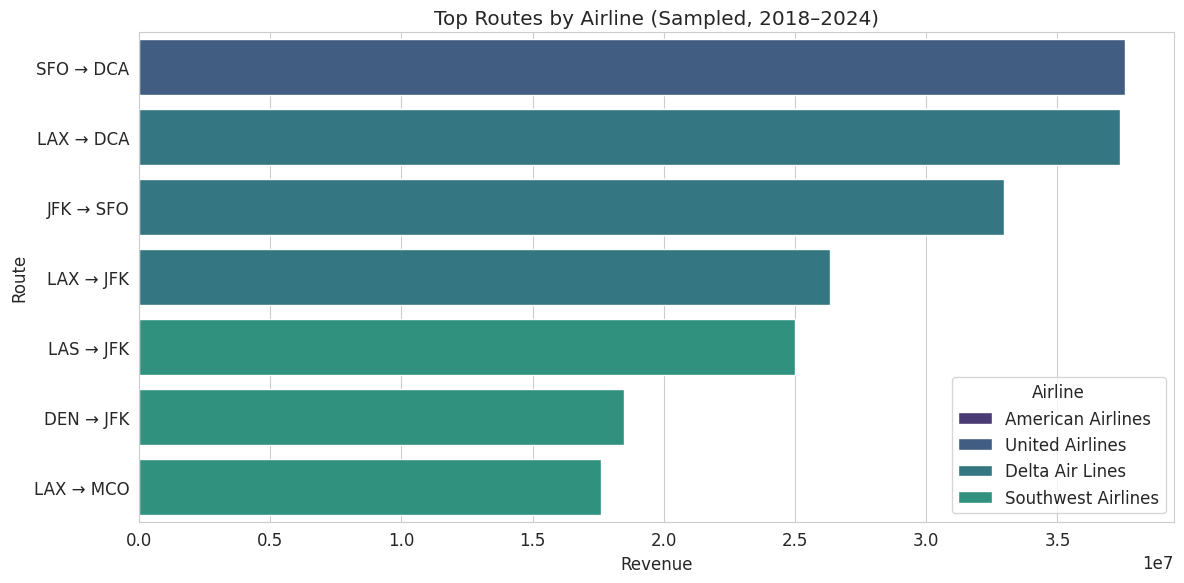

In [ ]:
# Profit Margin vs Revenue by Distance Bucket (2018–2024)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your cleaned DataFrame is named 'data'
df_filtered = data[(data['Year'] >= 2018) & (data['Year'] <= 2024)].copy()

# Calculate revenue and cost estimates
df_filtered['revenue'] = df_filtered['fare'] * df_filtered['passengers']
df_filtered['cost_estimate'] = df_filtered['nsmiles'] * df_filtered['passengers'] * 0.10  # Approximate $0.10 per mile
df_filtered['profit'] = df_filtered['revenue'] - df_filtered['cost_estimate']
df_filtered['profit_margin'] = df_filtered['profit'] / df_filtered['revenue']

# Group by distance buckets as proxy for route clusters
df_filtered['distance_bucket'] = pd.cut(
    df_filtered['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0-500mi', '501-1000mi', '1001-1500mi', '1501-2000mi', '2001-2500mi', '2501-3000mi']
)

# Aggregate by bucket
route_profit_df = df_filtered.groupby('distance_bucket')[['revenue', 'profit', 'profit_margin']].mean().reset_index()
route_profit_df = route_profit_df.sort_values(by='profit_margin', ascending=False)

# Display the result
print("Profit Margin vs Revenue by Distance Bucket (2018–2024):")
display(route_profit_df)

# Optional: visualize
plt.figure(figsize=(10,6))
sns.barplot(data=route_profit_df, x='distance_bucket', y='profit_margin')
plt.title('Average Profit Margin by Distance Bucket')
plt.ylabel('Profit Margin')
plt.xlabel('Distance Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


top_profit_routes = (
    df_clean.groupby(['airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .head(10)
)
top_profit_routes['route'] = top_profit_routes['airport_1'] + ' → ' + top_profit_routes['airport_2']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_profit_routes, x='revenue', y='route', palette='Blues_d')
plt.title("Top 10 Most Profitable Routes (2018–2024)")
plt.xlabel("Total Revenue")
plt.ylabel("Route")
plt.tight_layout()
plt.show()


df_clean['distance_bucket'] = pd.cut(
    df_clean['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0–500 mi', '501–1000 mi', '1001–1500 mi', '1501–2000 mi', '2001–2500 mi', '2501–3000 mi']
)

df_clean['cost_estimate'] = df_clean['nsmiles'] * df_clean['passengers'] * 0.10
df_clean['profit'] = df_clean['revenue'] - df_clean['cost_estimate']
df_clean['profit_margin'] = df_clean['profit'] / df_clean['revenue']

profit_by_bucket = (
    df_clean.groupby('distance_bucket')['profit_margin']
    .mean()
    .reset_index()
    .sort_values(by='profit_margin', ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=profit_by_bucket, x='distance_bucket', y='profit_margin', palette='Greens')
plt.title("Average Profit Margin by Distance Bucket (2018–2024)")
plt.xlabel("Distance Bucket")
plt.ylabel("Average Profit Margin")
plt.tight_layout()
plt.show()


quarterly = (
    df_clean[(df_clean['Year'] >= 2018) & (df_clean['Year'] <= 2024)]
    .groupby(['Year', 'quarter'])['revenue']
    .sum()
    .reset_index()
)
quarterly['YearQuarter'] = quarterly['Year'].astype(str) + ' Q' + quarterly['quarter'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=quarterly, x='YearQuarter', y='revenue', marker='o')
plt.title("Quarterly Revenue Trends (2018–2024)")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sampled_df = df_clean.dropna(subset=['possible_airlines']).sample(n=50000, random_state=42).explode('possible_airlines')

airline_perf = (
    sampled_df.groupby(['possible_airlines', 'airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .groupby('possible_airlines')
    .head(3)
)
airline_perf['route'] = airline_perf['airport_1'] + ' → ' + airline_perf['airport_2']

plt.figure(figsize=(12, 6))
sns.barplot(data=airline_perf, x='revenue', y='route', hue='possible_airlines', dodge=False)
plt.title("Top Routes by Airline (Sampled, 2018–2024)")
plt.xlabel("Revenue")
plt.ylabel("Route")
plt.legend(title="Airline")
plt.tight_layout()
plt.show()


In [ ]:
# Section 1: Prepare filtered data and node mapping
top_airports = df_clean['airport_1'].value_counts().nlargest(10).index
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(10).index
df_filtered = df_clean[
    df_clean['airport_1'].isin(top_airports) &
    df_clean['airport_2'].isin(top_airports) &
    df_clean['carrier_lg'].isin(top_carriers)
].copy()

all_nodes = pd.unique(df_filtered[['airport_1', 'carrier_lg', 'airport_2']].values.ravel())
node_map = {k: i for i, k in enumerate(all_nodes)}
periods = sorted(df_filtered['period'].unique())

print(f"\nFiltered shape: {df_filtered.shape}")
print(f"Periods: {periods}")

# Section 2: Link builder
def make_links(df):
    g = df.groupby(['airport_1', 'carrier_lg', 'airport_2']).size().reset_index(name='count')
    links = pd.concat([
        g.rename(columns={'airport_1': 'source', 'carrier_lg': 'target'})[['source', 'target', 'count']],
        g.rename(columns={'carrier_lg': 'source', 'airport_2': 'target'})[['source', 'target', 'count']]
    ])
    return {k: links[c].map(node_map).tolist() if c in ['source', 'target'] else links[c].tolist()
            for k, c in zip(['source', 'target', 'value'], ['source', 'target', 'count'])}

# Section 3: Build animation
frames = [go.Frame(name=str(p), data=[go.Sankey(node=dict(label=all_nodes), link=make_links(df_filtered[df_filtered['period'] == p]))])
          for p in periods]

fig = go.Figure(
    data=[go.Sankey(
        node=dict(pad=15, thickness=20, label=all_nodes, line=dict(color="black", width=0.5)),
        link=make_links(df_filtered[df_filtered['period'] == periods[0]])
    )],
    layout=go.Layout(
        title_text="Quarterly Airport → Carrier → Airport Flow",
        font_size=10,
        updatemenus=[{
            "type": "buttons", "buttons": [{
                "label": "Play", "method": "animate",
                "args": [None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}]
            }]
        }]
    ),
    frames=frames
)

fig.update_layout(sliders=[{
    "steps": [{"args": [[f.name], {"frame": {"duration": 500}, "mode": "immediate"}],
               "label": f.name, "method": "animate"} for f in frames],
    "x": 0.1, "xanchor": "left", "y": -0.2, "yanchor": "top"
}])

fig.show()


Filtered shape: (20672, 36)
Periods: [Period('1993Q1', 'Q-DEC'), Period('1993Q2', 'Q-DEC'), Period('1993Q3', 'Q-DEC'), Period('1993Q4', 'Q-DEC'), Period('1994Q1', 'Q-DEC'), Period('1996Q1', 'Q-DEC'), Period('1996Q2', 'Q-DEC'), Period('1996Q3', 'Q-DEC'), Period('1996Q4', 'Q-DEC'), Period('1997Q1', 'Q-DEC'), Period('1997Q2', 'Q-DEC'), Period('1997Q3', 'Q-DEC'), Period('1997Q4', 'Q-DEC'), Period('1998Q1', 'Q-DEC'), Period('1998Q2', 'Q-DEC'), Period('1998Q3', 'Q-DEC'), Period('1998Q4', 'Q-DEC'), Period('1999Q1', 'Q-DEC'), Period('1999Q2', 'Q-DEC'), Period('1999Q3', 'Q-DEC'), Period('1999Q4', 'Q-DEC'), Period('2000Q1', 'Q-DEC'), Period('2000Q2', 'Q-DEC'), Period('2000Q3', 'Q-DEC'), Period('2000Q4', 'Q-DEC'), Period('2001Q1', 'Q-DEC'), Period('2001Q2', 'Q-DEC'), Period('2001Q3', 'Q-DEC'), Period('2001Q4', 'Q-DEC'), Period('2002Q1', 'Q-DEC'), Period('2002Q2', 'Q-DEC'), Period('2002Q3', 'Q-DEC'), Period('2002Q4', 'Q-DEC'), Period('2003Q1', 'Q-DEC'), Period('2003Q2', 'Q-DEC'), Period('2003Q3',

## Full Forecasting Pipeline: From Aggregation to Model Evaluation

This notebook section implements a comprehensive forecasting pipeline that supports both **machine learning (ML)** and **statistical (ARIMA/SARIMA)** models. The pipeline handles quarterly airline data, performs dynamic feature engineering, evaluates multiple configurations, and identifies the best-performing forecast model.

---

### Section Overview

**Section 1 – Create Aggregated DataFrame**  
Aggregates the input DataFrame by quarter to compute total passengers, revenue, average fare, and derived metrics like log-revenue and revenue per passenger.

**Section 2 – Evaluation Metrics**  
Defines a unified scoring function to evaluate models using:
- Mean Absolute Percentage Error (MAPE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Coefficient of Determination (R²)
- Directional Accuracy (% of correct trend predictions)
- Custom Performance Score

**Section 3 – Period Handling & Feature Engineering**  
Functions to create training/testing periods and engineer lag, rolling, and change-based features.

**Section 4 – Data Splitting**  
Splits aggregated data into training and testing sets with safeguards for minimum size.

**Section 5 – Model Configuration Generator**  
Defines test configurations across various:
- Targets (e.g., `log_revenue`, `fare`)
- Feature sets (e.g., `lag_1`, `rolling_mean_4`)
- Algorithms (XGBoost, Random Forest, Linear Regression, ARIMA)
- Time ranges (1993–2019)

**Section 6 – ARIMA Model Fitting**  
Brute-force grid search over ARIMA and SARIMA parameters to find the best configuration using AIC.

**Section 7 – ARIMA Evaluation**  
Applies ARIMA to a test configuration and evaluates forecast performance on holdout data.

**Section 8 – ML Evaluation**  
Fits and tests ML models on selected features and target variables over a time window.

**Section 9 – Wrapper Function**  
Wraps ARIMA and ML model testing to unify the testing interface for downstream use.

**Section 10 – Run All Configurations**  
Executes hundreds of model/feature/start-date combinations, storing the best model results in `results_df` and identifying the top-performing setup.

**Section 11 – Forecasting with the Best Model**  
Supports recursive forecasting with either ARIMA or ML models. If the model is ML-based, generates features step-by-step for the forecast horizon and applies the trained model recursively.

**Section 12 – Run the Pipeline**  
Final invocation of the entire workflow. It:
- Builds `agg_df` from cleaned data
- Executes all model combinations
- Stores the best configuration and corresponding trained model


In [ ]:
# Section 1: Create aggregated DataFrame
def create_working_agg_df(df_clean):
    if 'period' not in df_clean.columns:
        df_clean = df_clean.copy()
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')

    agg_df = df_clean.groupby('period').agg({
        'fare': 'mean',
        'passengers': 'sum',
        'revenue': 'sum'
    }).sort_index()

    agg_df['log_revenue'] = np.log(agg_df['revenue'] + 1)
    agg_df['log_passengers'] = np.log(agg_df['passengers'] + 1)
    agg_df['revenue_per_passenger'] = agg_df['revenue'] / agg_df['passengers']

    print(f"agg_df: {agg_df.shape}, {agg_df.index.min()} to {agg_df.index.max()}")
    return agg_df

def calculate_performance_score(mape, rmse, mae, r2, directional_accuracy):
    """
    Calculate a universal composite performance score combining MAPE, RMSE, MAE, R2, and Directional Accuracy.
    All models treated equally.

    Arguments:
        mape: Mean Absolute Percentage Error (lower better)
        rmse: Root Mean Squared Error (lower better)
        mae: Mean Absolute Error (lower better)
        r2: R-squared (higher better)
        directional_accuracy: Directional Accuracy in percent (higher better)

    Returns:
        A performance score (higher is better)
    """
    # Normalize inputs (clamp values to avoid extreme values)
    norm_mape = min(mape, 1000) / 1000
    norm_rmse = min(rmse, 1000) / 1000
    norm_mae = min(mae, 1000) / 1000
    norm_r2 = max(0, r2)  # Clamp negative R2 to 0
    norm_da = directional_accuracy / 100

    # Fixed weights summing to 1
    weights = {
        'mape': 0.25,
        'rmse': 0.2,
        'mae': 0.1,
        'r2': 0.25,
        'da': 0.1
    }

    score = (
        weights['mape'] * (1 - norm_mape) +    # lower MAPE better
        weights['rmse'] * (1 - norm_rmse) +    # lower RMSE better
        weights['mae'] * (1 - norm_mae) +      # lower MAE better
        weights['r2'] * norm_r2 +              # higher R2 better
        weights['da'] * norm_da                # higher Directional Accuracy better
    )

    return score

# Section 2: Evaluation metrics
def calculate_model_metrics(actual, predicted):
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual, predicted = actual[mask], predicted[mask]
    if len(actual) == 0:
      return {'MAPE': float('inf'), 'RMSE': float('inf'), 'MAE': float('inf'),
              'R2': -float('inf'), 'Directional_Accuracy': 0, 'Performance_Score': -float('inf')}

    nonzero = actual != 0
    mape = np.mean(np.abs((actual[nonzero] - predicted[nonzero]) / actual[nonzero])) * 100 if np.any(nonzero) else float('inf')
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mae = np.mean(np.abs(actual - predicted))
    r2 = r2_score(actual, predicted)
    directional_accuracy = np.mean(np.sign(np.diff(actual)) == np.sign(np.diff(predicted))) * 100 if len(actual) > 1 else 0
    performance_score = calculate_performance_score(mape, rmse, mae, r2, directional_accuracy) # <-- added line here.
    return {'MAPE': mape, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Directional_Accuracy': directional_accuracy, 'Performance_Score': performance_score}


# Section 3: Period handling and feature creation
def create_periods(train_start, train_end, test_start='2020Q1'):
    return pd.Period(train_start, freq='Q'), pd.Period(train_end, freq='Q'), pd.Period(test_start, freq='Q')

def create_ml_features(df, target, feats):
    df = df[[target]].copy()
    df['quarter'], df['year'] = df.index.quarter, df.index.year
    if 'lag_1' in feats: df['lag_1'] = df[target].shift(1)
    if 'lag_4' in feats: df['lag_4'] = df[target].shift(4)
    if 'rolling_mean_4' in feats: df['rolling_mean_4'] = df[target].shift(1).rolling(4).mean()
    if 'pct_change_1' in feats: df['pct_change_1'] = df[target].pct_change(1)
    df['y'] = df[target]
    return df.dropna()


# Section 4: Train/test split
def split_data(df_feat, train_start_period, train_end_period, test_start_period):
    """Split data into train and test sets"""
    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)
    test_mask = df_feat.index >= test_start_period

    train_data = df_feat[train_mask]
    test_data = df_feat[test_mask]

    if len(train_data) < 20 or len(test_data) < 4:
        raise ValueError("Insufficient data")

    return train_data, test_data


# Section 5: Test configurations
def generate_test_configs():
    ml_targets = ['log_revenue', 'log_passengers', 'fare', 'revenue_per_passenger']
    arima_targets = ['revenue', 'passengers', 'fare', 'log_revenue', 'log_passengers', 'revenue_per_passenger']
    starts = ['1993Q1', '1997Q1','2000Q1', '2005Q1', '2008Q1', '2013Q1']  # 6 start periods
    feats = [['year', 'quarter', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4', 'pct_change_1'],
        ['quarter', 'lag_1', 'lag_4', 'rolling_mean_4'],
        ['year', 'quarter', 'lag_1', 'pct_change_1', 'rolling_mean_4'],
        ['quarter', 'lag_1', 'lag_2', 'pct_change_1'],
        ['lag_1', 'lag_2', 'lag_4', 'pct_change_1', 'rolling_mean_4'],
        ['quarter', 'lag_1'],
        ['quarter', 'lag_1', 'lag_4'],
        ['quarter', 'lag_1', 'rolling_mean_4'],
        ['year', 'quarter', 'lag_1'],
        ['year', 'quarter', 'lag_1', 'lag_4'],
        ['quarter', 'lag_4'],
        ['quarter', 'rolling_mean_4'],
        ['lag_1', 'lag_4'],
        ['quarter', 'pct_change_1'],
        ['lag_1', 'pct_change_1'],
    ]
    return [(t, f, m, s, '2019Q4') for s in starts for m in ['XGBoostRegression', 'RandomForest', 'LinearRegression'] for t in ml_targets for f in feats] + \
           [(t, ['ARIMA_auto'], 'ARIMA', s, '2019Q4') for s in starts for t in arima_targets]


# Section 6: Fit ARIMA (including SARIMA)
def fit_arima_model(train_data, target, test_index=None):
    ts = train_data[target]
    arima_cfgs = [(p, d, q, None) for p in range(3) for d in range(2) for q in range(3)]
    sarima_cfgs = [(p,d,q,(P,D,Q,4)) for p in range(2) for d in range(2) for q in range(2)
                   for P in range(2) for D in range(2) for Q in range(2) if P+D+Q > 0]
    best_aic = float('inf')
    for p,d,q,s in arima_cfgs + sarima_cfgs:
        try:
            model = ARIMA(ts, order=(p,d,q), seasonal_order=s) if s else ARIMA(ts, order=(p,d,q))
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_model, best_name = fitted, f"SARIMA{(p,d,q)}({','.join(map(str,s))})" if s else f"ARIMA{(p,d,q)}"
                best_aic = fitted.aic
        except: continue
    return (best_model, best_name) if best_aic < float('inf') else (ARIMA(ts, order=(1,1,1)).fit(), "ARIMA(1,1,1)")


# Section 7: Test ARIMA
def test_arima_model(agg_df, target, feats, t_start, t_end, test_idx=None, verbose_every=None):
    t0, t1, t2 = create_periods(t_start, t_end)
    ts_data = agg_df[[target]].copy()
    train, test = split_data(ts_data, t0, t1, t2)
    model, name = fit_arima_model(train, target, test_idx)
    forecast = model.forecast(steps=len(test))
    metrics = calculate_model_metrics(test[target].values, forecast)
    if verbose_every is None or (test_idx and test_idx % verbose_every == 0):
        prefix = f"Test {test_idx}: " if test_idx else ""
        print(f"{prefix}Best model for {target}: {name}, MAPE: {metrics['MAPE']:.1f}%, R²: {metrics['R2']:.3f}")
    return metrics, model, ts_data


# Section 8: Test ML model
def test_ml_model(agg_df, target, feats, model_type, t_start, t_end, test_idx=None, verbose_every=None):
    t0, t1, t2 = create_periods(t_start, t_end)
    df = create_ml_features(agg_df, target, feats)
    train, test = split_data(df, t0, t1, t2)
    X_train, y_train, X_test, y_test = train[feats], train['y'], test[feats], test['y']
    if model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'LinearRegression':
        model = LinearRegression()
    else:
        raise ValueError("Invalid model type")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    metrics = calculate_model_metrics(y_test.values, pred)
    if verbose_every is None or (test_idx and test_idx % verbose_every == 0):
        prefix = f"Test {test_idx}: " if test_idx else ""
        print(f"{prefix}Best model for {target}: {model_type}[{'+'.join(feats)}], MAPE: {metrics['MAPE']:.1f}%, R²: {metrics['R2']:.3f}")
    return metrics, model, df


# Section 9: Wrapper to run one test
def test_single_combination(df, target, feats, model_type, t_start, t_end, test_idx=None, total=None, verbose_every=100):
    return test_arima_model(df, target, feats, t_start, t_end, test_idx, verbose_every) if model_type == 'ARIMA' else \
           test_ml_model(df, target, feats, model_type, t_start, t_end, test_idx, verbose_every)


# Section 10: Run all model configurations
def test_high_combinations(agg_df, verbose_every=100):
    results, models = [], {}
    configs = generate_test_configs()
    print(f"Testing {len(configs)} configurations...")
    for i, (target, feats, mtype, t_start, t_end) in enumerate(configs):
        try:
            metrics, model, df_feat = test_single_combination(agg_df, target, feats, mtype, t_start, t_end, i+1, len(configs), verbose_every)
            name = f"{mtype}_{target}_{'+'.join(feats)}_{t_start}-{t_end}"
            results.append({**metrics, 'Config': name, 'Target': target, 'Features': feats, 'Model': mtype, 'Train_Period': f"{t_start}-{t_end}"})
            models[name] = {'model': model, 'df_feat': df_feat, 'target_var': target, 'features': feats, 'metrics': metrics}
            if (i + 1) % verbose_every == 0: print(f"  {i+1}/{len(configs)} configs tested...")
        except Exception as e:
            if mtype == 'ARIMA':
                print(f"  ARIMA failed for {target}: {str(e)[:50]}")
            continue
    results_df = pd.DataFrame(results)
    best_config = results_df.loc[results_df['Performance_Score'].idxmax()]
    print(f"\nBest: {best_config['Config']}\nMAPE = {best_config['MAPE']:.1f}%, R² = {best_config['R2']:.3f}, Directional Accuracy = {best_config['Directional_Accuracy']:.1f}%")
    return best_config, models[best_config['Config']], results_df


# Section 11: Forecast with best model
def create_forecast_features(feats, q, y, forecasts, i, val, history):
    d = {}
    if 'quarter' in feats: d['quarter'] = q
    if 'year' in feats: d['year'] = y
    if 'lag_1' in feats: d['lag_1'] = forecasts[i-1] if i > 0 else val
    if 'lag_4' in feats: d['lag_4'] = forecasts[i-4] if i >= 4 else history[-(4-i)] if i < 4 else history[-4]
    if 'rolling_mean_4' in feats:
        d['rolling_mean_4'] = np.mean((history + forecasts[:i])[-4:]) if i > 0 else np.mean(history[-4:])
    if 'pct_change_1' in feats:
        prev = forecasts[i-1] if i > 0 else history[-1]
        curr = forecasts[i-1] if i > 0 else val
        d['pct_change_1'] = (curr - prev) / prev if prev != 0 else 0
    return d

def generate_forecast_with_best(agg_df, best_cfg, best_model_info, periods=8):
    model, var, feats = best_model_info['model'], best_model_info['target_var'], best_model_info['features']
    if hasattr(model, 'forecast') and feats[0] == 'ARIMA_auto':
        forecasts = model.forecast(steps=periods)
        if var.startswith('log_'): forecasts = np.exp(forecasts) - 1
        return list(forecasts)
    forecasts, val = [], agg_df[var].iloc[-1]
    q, y = agg_df.index.max().quarter, agg_df.index.max().year
    history = list(agg_df[var].iloc[-8:])
    for i in range(periods):
        next_q = ((q + i - 1) % 4) + 1
        next_y = y + (q + i - 1) // 4
        x = create_forecast_features(feats, next_q, next_y, forecasts, i, val, history)
        pred_df = pd.DataFrame([x])[feats]
        forecasts.append(model.predict(pred_df)[0])
    if var in ['revenue', 'log_revenue']:
        return [np.exp(f) - 1 if var == 'log_revenue' else f for f in forecasts]
    ratio = agg_df['revenue'].iloc[-1] / agg_df[var].iloc[-1] if agg_df[var].iloc[-1] != 0 else 1
    return [f * ratio for f in forecasts]


# Section 12: Run pipeline
agg_df = create_working_agg_df(df_clean)
best_config, best_model_info, results_df = test_high_combinations(agg_df, verbose_every=100)

agg_df: (118, 6), 1993Q1 to 2024Q1
Testing 1116 configurations...
Test 100: Best model for fare: RandomForest[year+quarter+lag_1+lag_4], MAPE: 12.4%, R²: -0.051
  100/1116 configs tested...
Test 300: Best model for revenue_per_passenger: RandomForest[lag_1+pct_change_1], MAPE: 5.8%, R²: 0.716
  300/1116 configs tested...
Test 400: Best model for fare: XGBoostRegression[year+quarter+lag_1+lag_4], MAPE: 11.4%, R²: 0.130
  400/1116 configs tested...
Test 600: Best model for revenue_per_passenger: XGBoostRegression[lag_1+pct_change_1], MAPE: 5.6%, R²: 0.720
  600/1116 configs tested...
Test 700: Best model for fare: LinearRegression[year+quarter+lag_1+lag_4], MAPE: 7.2%, R²: 0.541
  700/1116 configs tested...
Test 900: Best model for revenue_per_passenger: LinearRegression[lag_1+pct_change_1], MAPE: 1.0%, R²: 0.992
  900/1116 configs tested...
Test 1000: Best model for fare: RandomForest[year+quarter+lag_1+lag_4], MAPE: 13.6%, R²: -0.222
  1000/1116 configs tested...
Test 1100: Best model 

### Forecasting with Regression Models and Custom Train/Test Periods

This section defines a flexible function to train, evaluate, and visualize forecasts using various regression models and hand-selected quarterly time windows for training and testing.

In [ ]:
def forecast_with_features(agg_df, target_var, features, train_start, train_end, test_start, test_end,
    model_type='LinearRegression'):
    """
    Trains a regression model on given features and target with flexible train/test periods,
    plots results, and prints evaluation metrics.

    Parameters:
    - agg_df: pd.DataFrame indexed by pd.Period quarterly (e.g., 1993Q1)
    - target_var: str, target variable column name (e.g., 'log_revenue')
    - features: list of str, feature column names to use for prediction
    - train_start, train_end: str, training period start/end (e.g., '1993Q1')
    - test_start, test_end: str, testing period start/end (e.g., '2020Q1')
    - model_type: str, supports 'LinearRegression', 'RandomForest', 'XGBoostRegression'

    Returns:
    - model: trained model object
    - df_feat: DataFrame with features and target after preprocessing
    - metrics: dict with performance scores
    """

    # Step 1: Prepare features
    df_feat = create_ml_features(agg_df, target_var, features)

    # Step 2: Define period masks
    train_start_period = pd.Period(train_start, freq='Q')
    train_end_period = pd.Period(train_end, freq='Q')
    test_start_period = pd.Period(test_start, freq='Q')
    test_end_period = pd.Period(test_end, freq='Q')

    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)
    test_mask = (df_feat.index >= test_start_period) & (df_feat.index <= test_end_period)

    # Step 3: Split data
    X_train = df_feat.loc[train_mask, features]
    y_train = df_feat.loc[train_mask, 'y']
    X_test = df_feat.loc[test_mask, features]
    y_test = df_feat.loc[test_mask, 'y']

    # Step 4: Select model
    if model_type == 'LinearRegression':
        model = LinearRegression()
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    else:
        raise NotImplementedError(f"Model type {model_type} not supported.")

    # Step 5: Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Step 6: Metrics (use unified function)
    metrics = calculate_model_metrics(y_test.values, y_pred)

    # Step 7: Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_feat.loc[train_mask].index.to_timestamp(), y_train, label='Train Actual', color='blue')
    plt.plot(df_feat.loc[test_mask].index.to_timestamp(), y_test, label='Test Actual', color='green')
    plt.plot(df_feat.loc[test_mask].index.to_timestamp(), y_pred, label='Test Predicted', color='red', linestyle='--')

    plt.title(f'{model_type} Forecast of {target_var}\n(Features: {", ".join(features)})')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 8: Print metrics
    print(f"{model_type} Model Error (Test Set: {test_start}–{test_end}):")
    print(f"  R²:   {metrics['R2']:.4f}")
    print(f"  MAE:  {metrics['MAE']:,.2f}")
    print(f"  RMSE: {metrics['RMSE']:,.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")
    print(f"  Performance Score: {metrics['Performance_Score']:.3f}")

    return model, df_feat, metrics


In [ ]:
def forecast_with_features(agg_df, target_var, features, train_start, train_end, test_start, test_end,
    model_type='LinearRegression'):

    df_feat = create_ml_features(agg_df, target_var, features)

    train_start_period = pd.Period(train_start, freq='Q')
    train_end_period = pd.Period(train_end, freq='Q')
    test_start_period = pd.Period(test_start, freq='Q')
    test_end_period = pd.Period(test_end, freq='Q')

    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)
    test_mask = (df_feat.index >= test_start_period) & (df_feat.index <= test_end_period)

    X_train = df_feat.loc[train_mask, features]
    y_train = df_feat.loc[train_mask, 'y']
    X_test = df_feat.loc[test_mask, features]
    y_test = df_feat.loc[test_mask, 'y']

    if model_type == 'LinearRegression':
        model = LinearRegression()
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    else:
        print(f"Unsupported model '{model_type}', defaulting to LinearRegression.")
        model_type = 'LinearRegression'
        model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = calculate_model_metrics(y_test.values, y_pred)

    plt.figure(figsize=(14, 6))
    plt.plot(df_feat.loc[train_mask].index.to_timestamp(), y_train, label='Train Actual', color='blue')
    plt.plot(df_feat.loc[test_mask].index.to_timestamp(), y_test, label='Test Actual', color='green')
    plt.plot(df_feat.loc[test_mask].index.to_timestamp(), y_pred, label='Test Predicted', color='red', linestyle='--')
    plt.title(f'{model_type} Forecast of {target_var}\n(Features: {", ".join(features)})')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{model_type} Model Error (Test Set: {test_start}–{test_end}):")
    print(f"  R²:   {metrics['R2']:.4f}")
    print(f"  MAE:  {metrics['MAE']:,.2f}")
    print(f"  RMSE: {metrics['RMSE']:,.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")
    print(f"  Performance Score: {metrics['Performance_Score']:.3f}")

    return model, df_feat, metrics


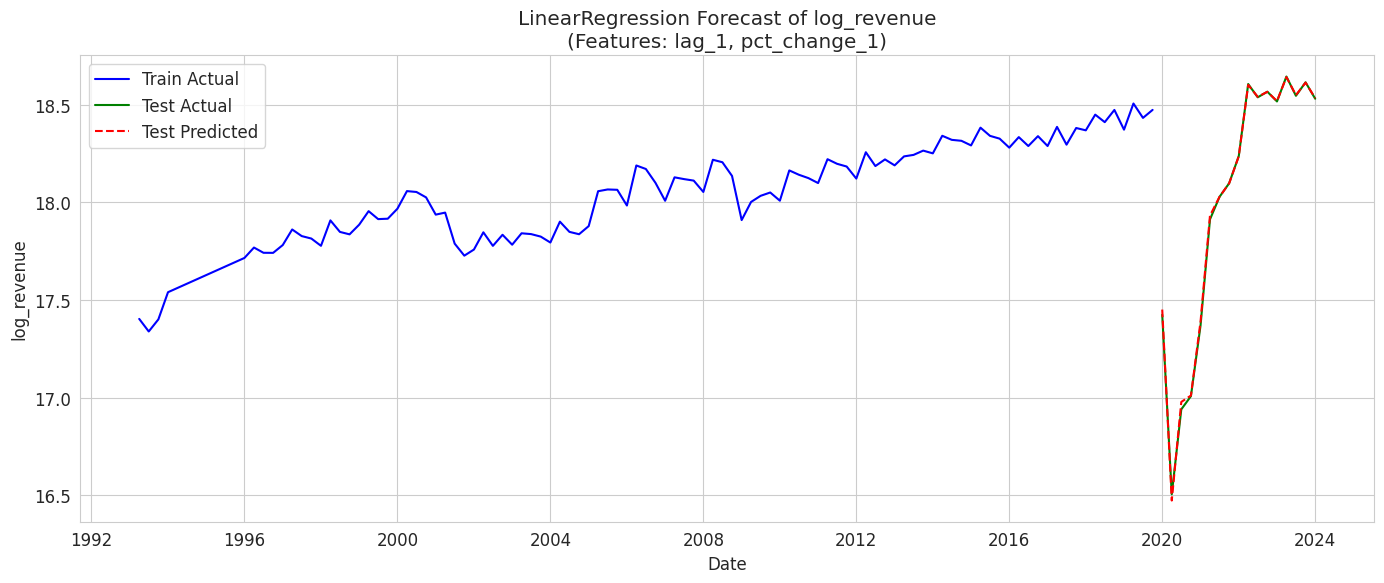

LinearRegression Model Error (Test Set: 2020Q1–2024Q1):
  R²:   0.9995
  MAE:  0.01
  RMSE: 0.02
  MAPE: 0.05%
  Directional Accuracy: 100.00%
  Performance Score: 0.900


In [ ]:
model, df_feat, metrics = forecast_with_features(
    agg_df,
    'log_revenue',
    ['lag_1', 'pct_change_1'],
    '1993Q1',
    '2019Q4',
    '2020Q1',
    '2024Q1',
    model_type='LinearRegression'
)

In [ ]:
def forecast_future_periods_iterative(agg_df, target_var, features, train_start, train_end, forecast_periods=8, model_type='LinearRegression'):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor

    # Create ML features DataFrame
    df_feat = create_ml_features(agg_df, target_var, features)

    # Define training periods
    train_start_period = pd.Period(train_start, freq='Q')
    train_end_period = pd.Period(train_end, freq='Q')

    # Train mask
    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)

    # Prepare training data: drop NaNs
    X_train = df_feat.loc[train_mask, features].dropna()
    y_train = df_feat.loc[train_mask, 'y'].loc[X_train.index]

    # Initialize model
    if model_type == 'LinearRegression':
        model = LinearRegression()
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    else:
        print(f"Unsupported model '{model_type}', defaulting to LinearRegression.")
        model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Prepare for iterative forecasting
    last_period = df_feat.index.max()
    future_periods = [last_period + i for i in range(1, forecast_periods + 1)]

    # Start from existing data
    current_df = df_feat.copy()

    future_preds = []

    for period in future_periods:
        # Calculate features for the new period:
        # lag_1 = y value from previous period (last known or predicted)
        lag_1 = current_df['y'].iloc[-1]

        # pct_change_1 = percent change between last two known/predicted y values
        if len(current_df) >= 2:
            pct_change_1 = (current_df['y'].iloc[-1] - current_df['y'].iloc[-2]) / current_df['y'].iloc[-2]
        else:
            pct_change_1 = 0  # or np.nan and fill it later

        # Build feature vector for this period
        X_pred = pd.DataFrame({
            'lag_1': [lag_1],
            'pct_change_1': [pct_change_1],
            # add any other features here, or derive as needed
        }, index=[period])

        # Predict y for the new period
        y_pred = model.predict(X_pred)[0]

        # Append prediction to future_preds list
        future_preds.append((period, y_pred))

        # Append new row with predicted y for next iteration’s features
        new_row = pd.DataFrame({'y': y_pred}, index=[period])
        current_df = pd.concat([current_df, new_row])

    # Create future_df with predictions
    future_df = pd.DataFrame(future_preds, columns=['period', 'y_pred']).set_index('period')

    # Plot results
    plt.figure(figsize=(14,6))
    plt.plot(df_feat.index.to_timestamp(), df_feat['y'], label='Historical')
    plt.plot(future_df.index.to_timestamp(), future_df['y_pred'], label='Forecast (iterative)', linestyle='--')
    plt.title(f'Forecast for {target_var} using {model_type} (Iterative)')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, current_df, future_df

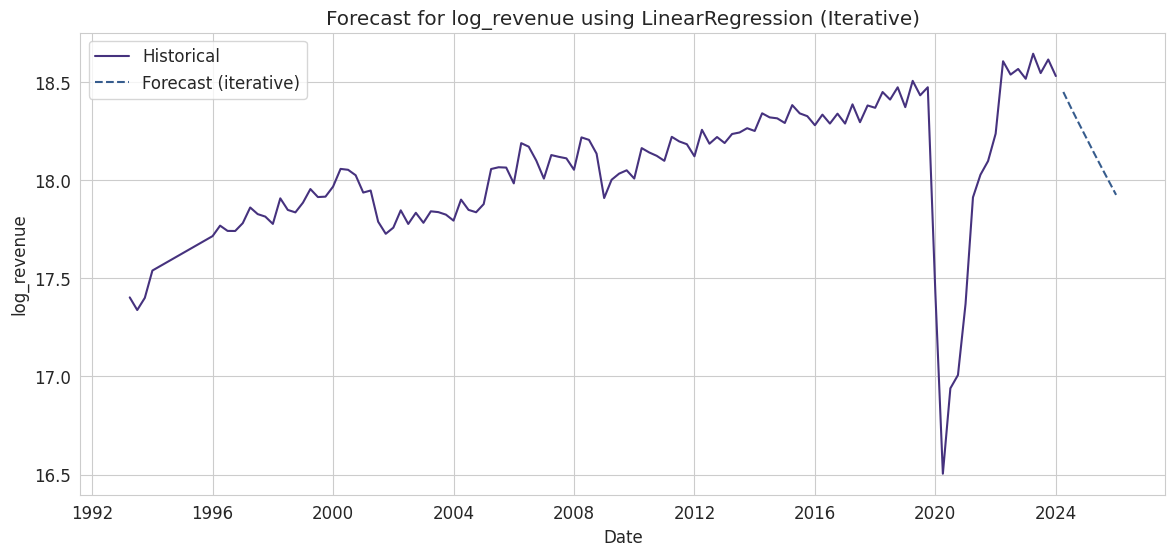

In [ ]:
model, full_df, forecast_df = forecast_future_periods_iterative(
    agg_df, 'log_revenue', ['lag_1', 'pct_change_1'],
    '1993Q1', '2019Q4', forecast_periods=8, model_type='LinearRegression'
)

### Forecast Generation Using Best Model

This section defines the logic for generating multi-step forecasts using either classical time series models (e.g., ARIMA) or machine learning models (e.g., Linear Regression, Random Forest, XGBoost).

In [ ]:
def create_forecast_features(features, next_quarter, next_year, forecasts, i, current_value, recent_values):
    """
    Create a single row of features for the next forecast step.

    Args:
        features: list of feature names to include
        next_quarter: int (1–4)
        next_year: int
        forecasts: list of previously predicted values
        i: current forecast step (0-based)
        current_value: last known actual value
        recent_values: list of most recent actual values

    Returns:
        dict of features for the ML model
    """
    feature_dict = {}

    if 'quarter' in features:
        feature_dict['quarter'] = next_quarter
    if 'year' in features:
        feature_dict['year'] = next_year
    if 'lag_1' in features:
        feature_dict['lag_1'] = forecasts[i - 1] if i > 0 else current_value
    if 'lag_4' in features:
        if i >= 4:
            feature_dict['lag_4'] = forecasts[i - 4]
        else:
            feature_dict['lag_4'] = recent_values[-(4 - i)]
    if 'rolling_mean_4' in features:
        if i > 0:
            recent_and_forecast = recent_values + forecasts[:i]
            feature_dict['rolling_mean_4'] = np.mean(recent_and_forecast[-4:])
        else:
            feature_dict['rolling_mean_4'] = np.mean(recent_values[-4:])
    if 'pct_change_1' in features:
        if i > 0:
            prev_value = forecasts[i - 1]
        else:
            prev_value = recent_values[-1]
        current_pred_value = forecasts[i - 1] if i > 0 else current_value
        feature_dict['pct_change_1'] = (current_pred_value - prev_value) / prev_value if prev_value != 0 else 0

    return feature_dict


def generate_forecast_with_best(agg_df, best_config, best_model_info, periods=8, target_conversion='revenue'):
    """
    Generate future forecasts using the best model (ARIMA or ML).

    Args:
        agg_df: DataFrame with period index and model features/targets
        best_config: row from results_df with model metadata
        best_model_info: dict with keys: model, target_var, features, etc.
        periods: int, number of quarters to forecast
        target_conversion: str, final target to scale to ('revenue' or None)

    Returns:
        list of predicted revenue values
    """
    model = best_model_info['model']
    target_var = best_model_info['target_var']
    features = best_model_info['features']

    # --- Case 1: ARIMA/SARIMA ---
    if hasattr(model, 'forecast') and features[0] == 'ARIMA_auto':
        forecasts = model.forecast(steps=periods)

        # If log-transformed target, reverse it
        if target_var.startswith('log_'):
            forecasts = np.exp(forecasts) - 1

        forecasts = list(forecasts)

    # --- Case 2: ML model recursive prediction ---
    else:
        forecasts = []
        current_value = agg_df[target_var].iloc[-1]
        last_quarter = agg_df.index.max().quarter
        last_year = agg_df.index.max().year
        recent_values = list(agg_df[target_var].iloc[-8:])

        for i in range(periods):
            next_quarter = ((last_quarter + i - 1) % 4) + 1
            next_year = last_year + (last_quarter + i - 1) // 4

            feature_dict = create_forecast_features(
                features, next_quarter, next_year,
                forecasts, i, current_value, recent_values
            )

            pred_df = pd.DataFrame([feature_dict])[features]
            forecast = model.predict(pred_df)[0]
            forecasts.append(forecast)

        # Reverse log transform if needed
        if target_var.startswith('log_'):
            forecasts = [np.exp(f) - 1 for f in forecasts]

    # --- Post-processing: scale to revenue if needed ---
    if target_var == 'revenue':
        revenue_forecasts = forecasts
    else:
        current_revenue = agg_df['revenue'].iloc[-1]
        current_target = agg_df[target_var].iloc[-1]
        conversion_ratio = current_revenue / current_target if current_target != 0 else 1
        revenue_forecasts = [f * conversion_ratio for f in forecasts]

    return revenue_forecasts


In [ ]:
# Performance analysis
print("\nModel Performance by Type:")
for model_type in ['XGBoostRegression', 'RandomForest', 'LinearRegression', 'ARIMA']:
    model_results = results_df[results_df['Model'] == model_type].sort_values('Performance_Score', ascending=False)
    if len(model_results) > 0:
        best_model = model_results.iloc[0]
        print(f"\n{model_type}:")
        print(f"  Best MAPE: {best_model['MAPE']:.1f}%")
        print(f"  Best R²: {best_model['R2']:.3f}")
        print(f"  Best Directional Accuracy: {best_model['Directional_Accuracy']:.1f}%")
        print(f"  Best Config: {best_model['Config']}")
        if len(model_results) > 1:
            print(f"  Top 3 MAPE scores: {model_results['MAPE'].head(3).tolist()}")
            print(f"  Top 3 R² scores: {model_results['R2'].head(3).tolist()}")

forecasts = generate_forecast_with_best(agg_df, best_config, best_model_info)

current_revenue = agg_df['revenue'].iloc[-1]
forecast_final = forecasts[-1]
annual_growth = ((forecast_final / current_revenue) ** 0.5 - 1) * 100


Model Performance by Type:

XGBoostRegression:
  Best MAPE: 4.5%
  Best R²: 0.823
  Best Directional Accuracy: 93.8%
  Best Config: XGBoostRegression_revenue_per_passenger_lag_1+pct_change_1_1993Q1-2019Q4
  Top 3 MAPE scores: [4.525261144924297, 5.082031572391527, 5.005631363687668]
  Top 3 R² scores: [0.8227041307588006, 0.7810855711917161, 0.7832659337513678]

RandomForest:
  Best MAPE: 5.9%
  Best R²: 0.731
  Best Directional Accuracy: 100.0%
  Best Config: RandomForest_revenue_per_passenger_lag_1+pct_change_1_1993Q1-2019Q4
  Top 3 MAPE scores: [5.902664397766523, 5.839905218252187, 4.459478148183655]
  Top 3 R² scores: [0.7314674182078328, 0.716120933045758, 0.7553523901358501]

LinearRegression:
  Best MAPE: 0.1%
  Best R²: 1.000
  Best Directional Accuracy: 100.0%
  Best Config: LinearRegression_log_revenue_year+quarter+lag_1+pct_change_1+rolling_mean_4_1993Q1-2019Q4
  Top 3 MAPE scores: [0.05451046501665866, 0.05488420486633637, 0.05599033507743766]
  Top 3 R² scores: [0.999501

### Model Performance Comparison by Feature Combinations and Target Variables

This section visualizes model performance across different feature engineering strategies, target variables, and model types.

---

#### Feature Combination Analysis

We evaluate how different feature sets perform across multiple models using the following metrics:

- **MAPE** (Mean Absolute Percentage Error) – Lower is better
- **MAE** (Mean Absolute Error) – Lower is better
- **R²** (Coefficient of Determination) – Higher is better
- **Directional Accuracy** – Percentage of correct trend direction (higher is better)

For each `(Feature Combination, Model)` pair:
- The **best-performing configuration** is selected based on each metric.
- Feature combinations are stringified for display purposes.
- Results are visualized using grouped bar plots for each metric.

These plots help identify:
- Which features are consistently useful across models
- Which model–feature combos yield the best results for different metrics

#### Target Variable Analysis

We also visualize **model performance across target variables**:

- For each `(Target, Model)` pair, the configuration with the **lowest MAPE** is retained.
- A grouped bar chart displays the best MAPE achieved per target variable and model.

This view is helpful for:
- Comparing model behavior across different forecasting targets (e.g., `fare`, `log_revenue`, etc.)
- Highlighting which targets are easier or harder to forecast

#### Scatter Plots: Directional Accuracy vs. MAPE

We plot each model configuration in a **2D space** of:

- X-axis: MAPE (%)
- Y-axis: Directional Accuracy (%)

Two versions are plotted:
- **All models**, including ARIMA
- **Filtered**, excluding ARIMA models (to focus on supervised ML models)

In [ ]:
def prepare_feature_columns(df):
    if 'Features_str' not in df.columns:
        df['Features_str'] = df['Features'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) else str(x)
        )
    return df

def shorten_features_string(s, maxlen=30):
    return s if len(s) <= maxlen else s[:maxlen] + '...'

def prepare_short_features(df):
    df['Features_short'] = df['Features'].apply(
        lambda x: shorten_features_string(', '.join(x)) if isinstance(x, list) else str(x)
    )
    return df

# --- Plot best metric grouped by (Features, Model) ---
def plot_best_metric_by_features(results_df, metric, maximize=True, use_short_labels=False):
    results_df = prepare_feature_columns(results_df)
    if use_short_labels:
        results_df = prepare_short_features(results_df)
        label_col = 'Features_short'
    else:
        label_col = 'Features_str'

    grouped = results_df.groupby([label_col, 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(14, 7))
    sns.barplot(data=best_df, x=label_col, y=metric, hue='Model')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Best {metric} by Feature Combination and Model')
    plt.ylabel(metric)
    plt.xlabel('Feature Combination')
    plt.legend(title='Model', loc='upper right')
    plt.tight_layout()
    plt.show()

# --- Plot best metric grouped by (Target, Model) ---
def plot_best_metric_by_target(results_df, metric='MAPE', maximize=False):
    grouped = results_df.groupby(['Target', 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=best_df, x='Target', y=metric, hue='Model')
    plt.title(f'Best {metric} by Target Variable and Model Type')
    plt.ylabel(f'Best {metric}')
    plt.xlabel('Target Variable')
    plt.xticks(rotation=45)
    plt.legend(title='Model Type')
    plt.tight_layout()
    plt.show()

# --- Scatter plot: Directional Accuracy vs MAPE ---
def prepare_feature_columns(df):
    if 'Features_str' not in df.columns:
        df['Features_str'] = df['Features'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) else str(x)
        )
    return df

def shorten_features_string(s, maxlen=30):
    return s if len(s) <= maxlen else s[:maxlen] + '...'

def prepare_short_features(df):
    df['Features_short'] = df['Features'].apply(
        lambda x: shorten_features_string(', '.join(x)) if isinstance(x, list) else str(x)
    )
    return df

# --- Plot best metric grouped by (Features, Model) ---
def plot_best_metric_by_features(results_df, metric, maximize=True, use_short_labels=False):
    results_df = prepare_feature_columns(results_df)
    if use_short_labels:
        results_df = prepare_short_features(results_df)
        label_col = 'Features_short'
    else:
        label_col = 'Features_str'

    grouped = results_df.groupby([label_col, 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(14, 7))
    sns.barplot(data=best_df, x=label_col, y=metric, hue='Model')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Best {metric} by Feature Combination and Model')
    plt.ylabel(metric)
    plt.xlabel('Feature Combination')
    plt.legend(title='Model', loc='upper right')
    plt.tight_layout()
    plt.show()

# --- Plot best metric grouped by (Target, Model) ---
def plot_best_metric_by_target(results_df, metric='MAPE', maximize=False):
    grouped = results_df.groupby(['Target', 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=best_df, x='Target', y=metric, hue='Model')
    plt.title(f'Best {metric} by Target Variable and Model Type')
    plt.ylabel(f'Best {metric}')
    plt.xlabel('Target Variable')
    plt.xticks(rotation=45)
    plt.legend(title='Model Type')
    plt.tight_layout()
    plt.show()

# --- Scatter plot: Directional Accuracy vs MAPE ---
def scatter_directional_accuracy_vs_mape(results_df, exclude_arima=False):
    df = results_df.copy()

    if exclude_arima:
        df = df[~df['Model'].str.contains('ARIMA')]

        # Force RandomForest to plot last (on top) by ordering the data
        model_order = ['LinearRegression', 'XGBoostRegression', 'RandomForest']
        df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
        df = df.sort_values('Model')

    plt.figure(figsize=(10, 6))

    if exclude_arima:
        # Match the original code exactly: hue=Model, style=Target, palette=Set2
        # But specify explicit colors to match your target image
        colors = ['#4daf4a', '#ff7f00', '#377eb8']  # Green, Orange, Blue (Set2 order)
        sns.scatterplot(
            data=df,
            x='MAPE',
            y='Directional_Accuracy',
            hue='Model',        # Colors by Model
            style='Target',     # Shapes by Target
            palette=colors,     # Explicit colors in the right order
            s=80
        )
        plt.title('Directional Accuracy vs. MAPE (Non-ARIMA Models)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        # For ARIMA plot: hue=Model, style=Model (both use Model)
        sns.scatterplot(
            data=df,
            x='MAPE',
            y='Directional_Accuracy',
            hue='Model',
            style='Model',
            s=100,
            alpha=0.7
        )
        plt.title('Directional Accuracy vs MAPE (including ARIMA)')
        plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.xlabel('MAPE (%)')
    plt.ylabel('Directional Accuracy (%)')
    plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.8)
    plt.axhline(y=50, color='gray', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    # For ARIMA plot: hue=Model, style=Model (both use Model)
    sns.scatterplot(
        data=df,
        x='MAPE',
        y='Directional_Accuracy',
        hue='Model',
        style='Model',
        s=100,
        alpha=0.7
    )
    plt.title('Directional Accuracy vs MAPE (including ARIMA)')
    plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.xlabel('MAPE (%)')
    plt.ylabel('Directional Accuracy (%)')
    plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.8)
    plt.axhline(y=50, color='gray', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

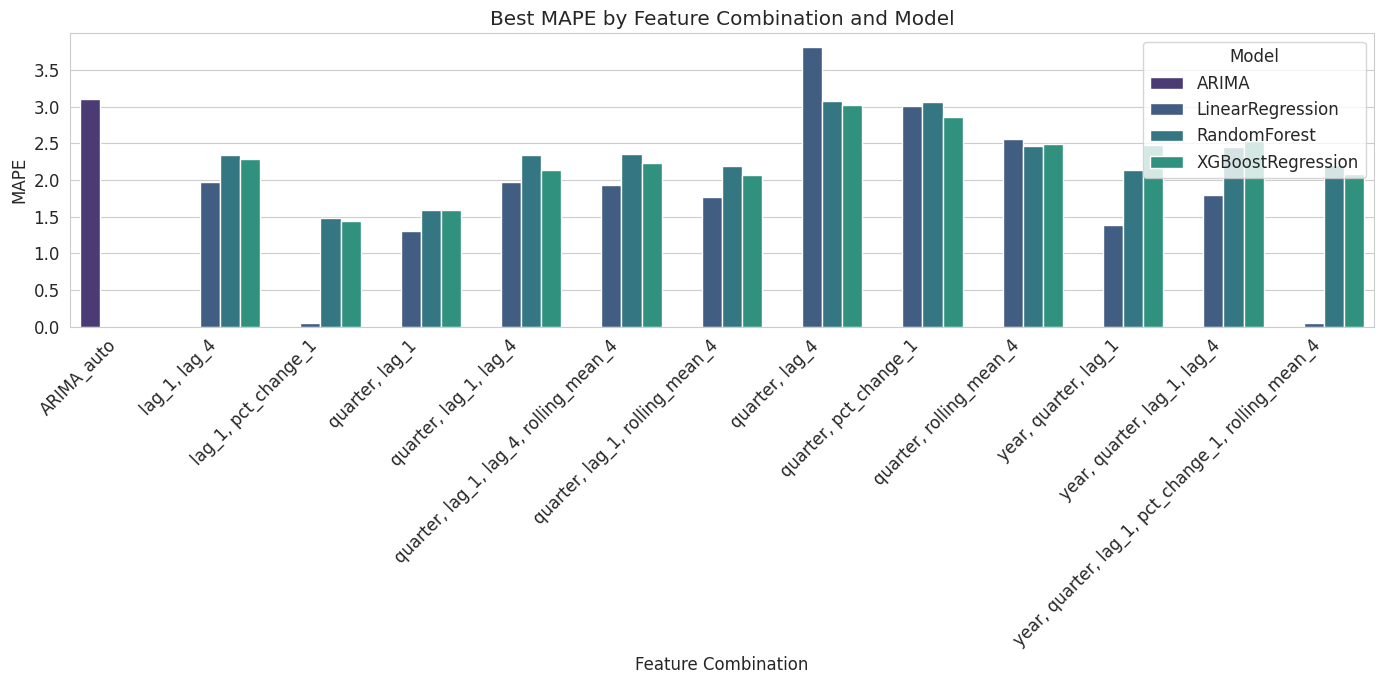

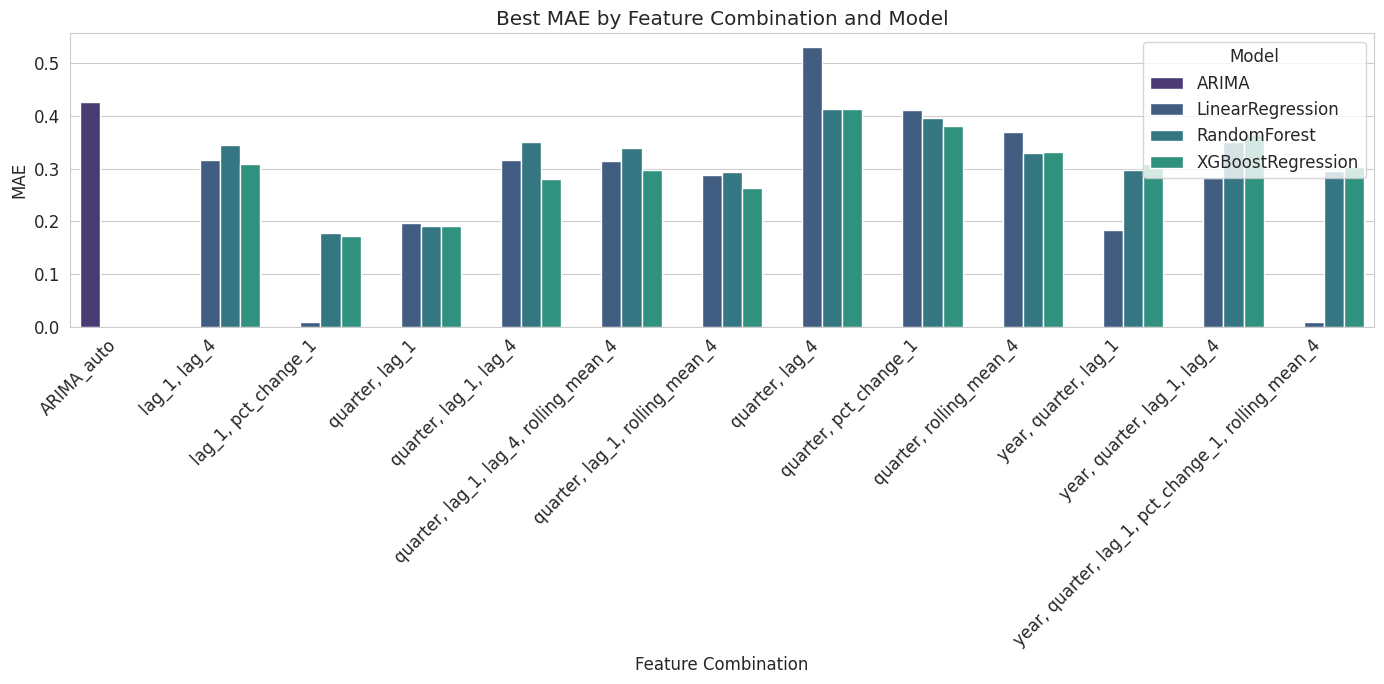

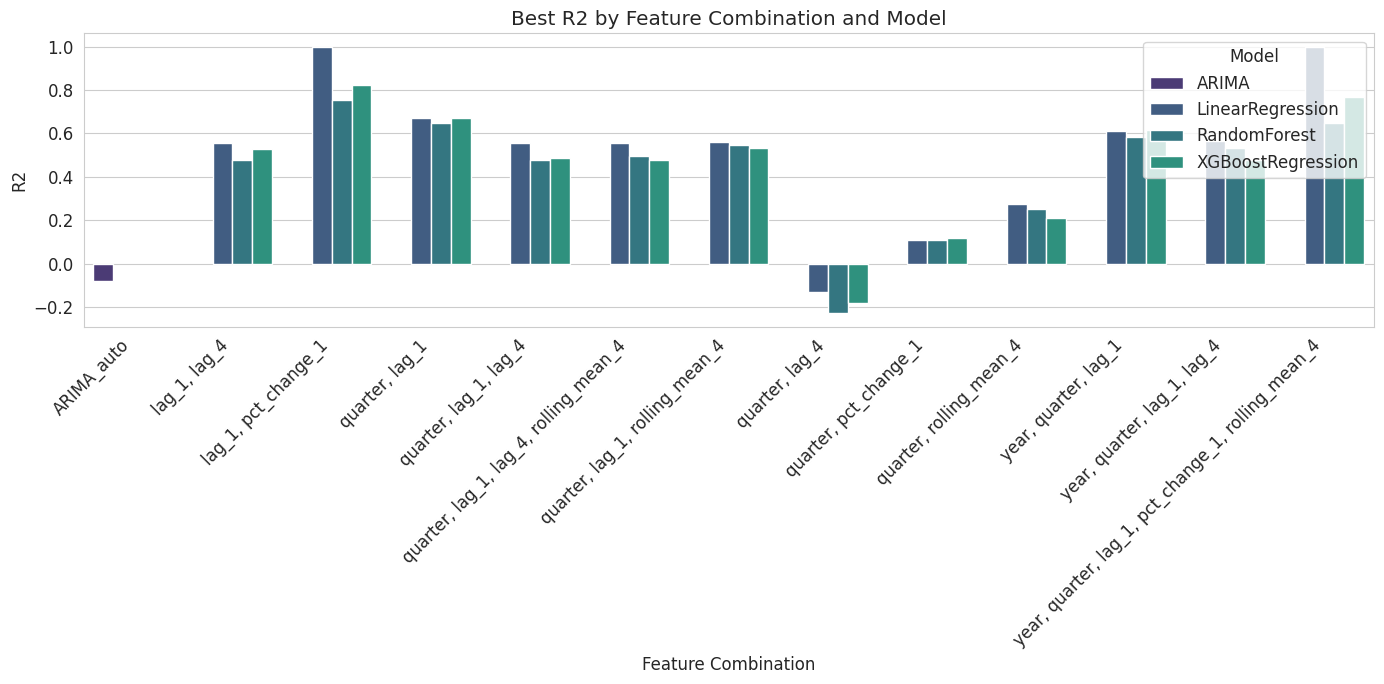

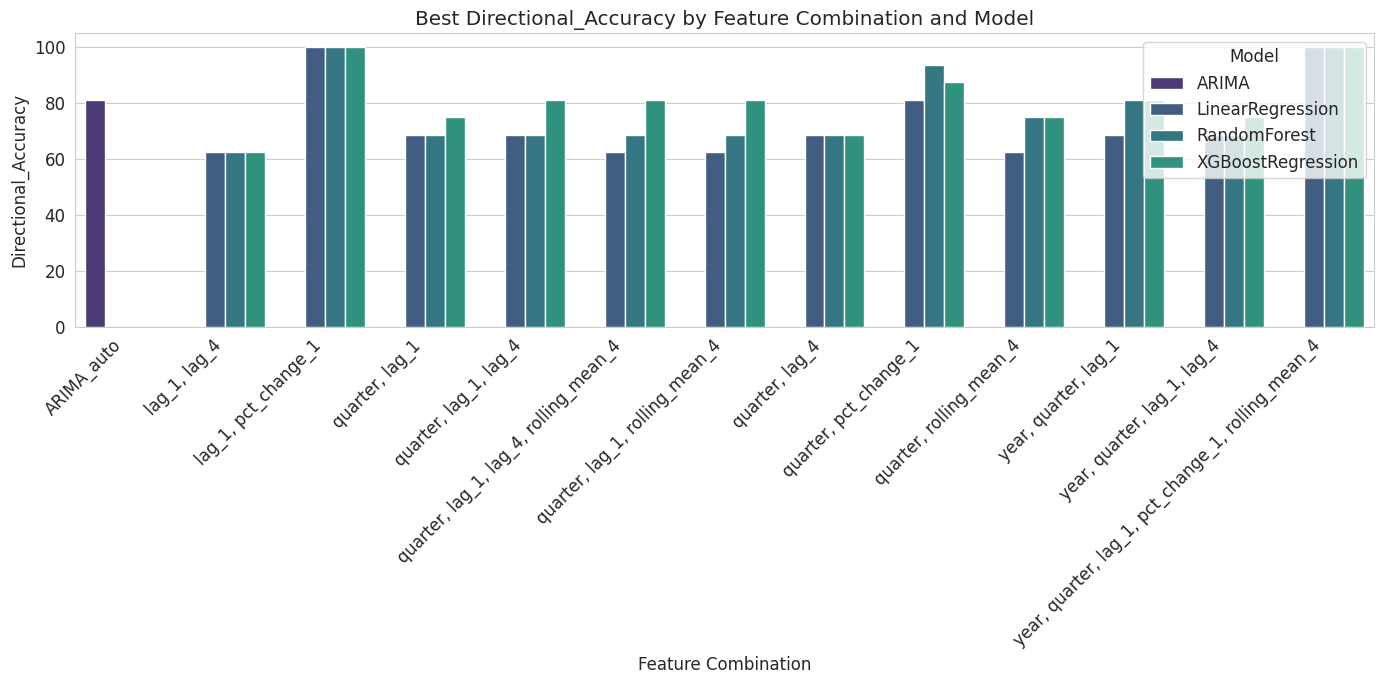

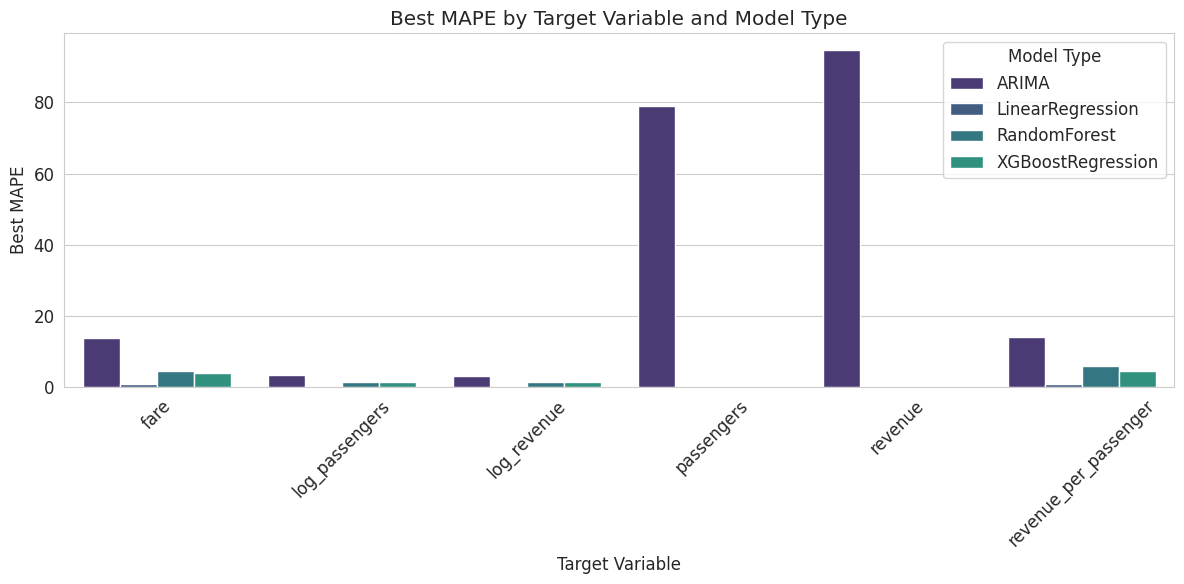

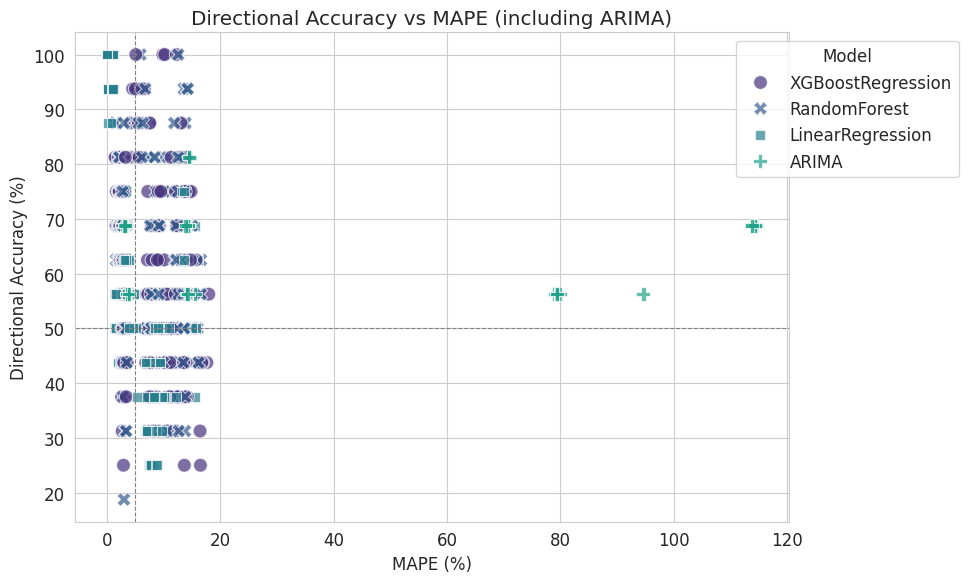

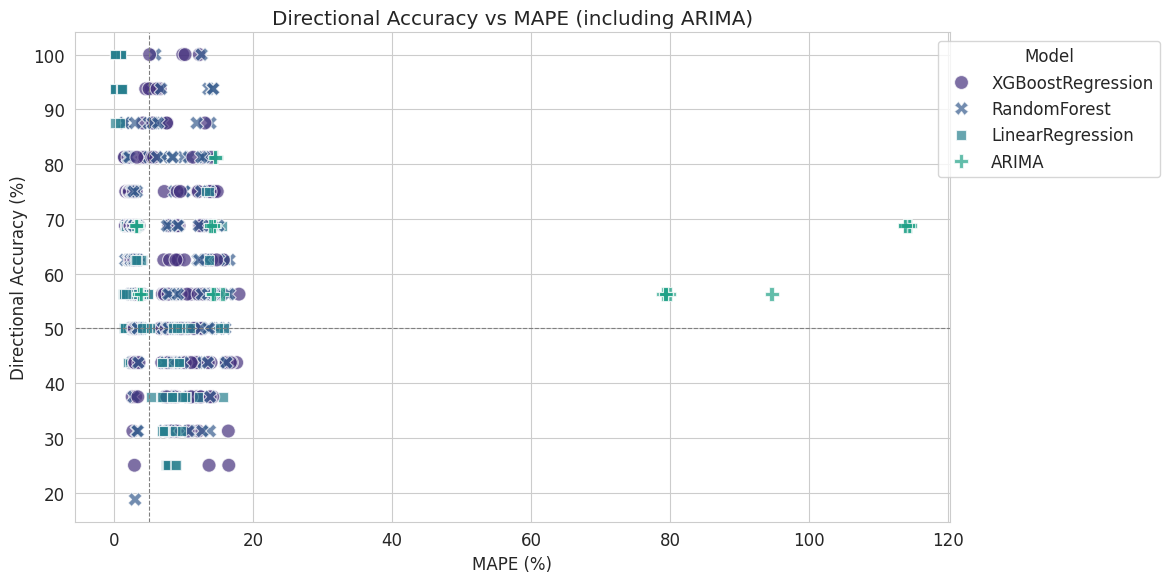

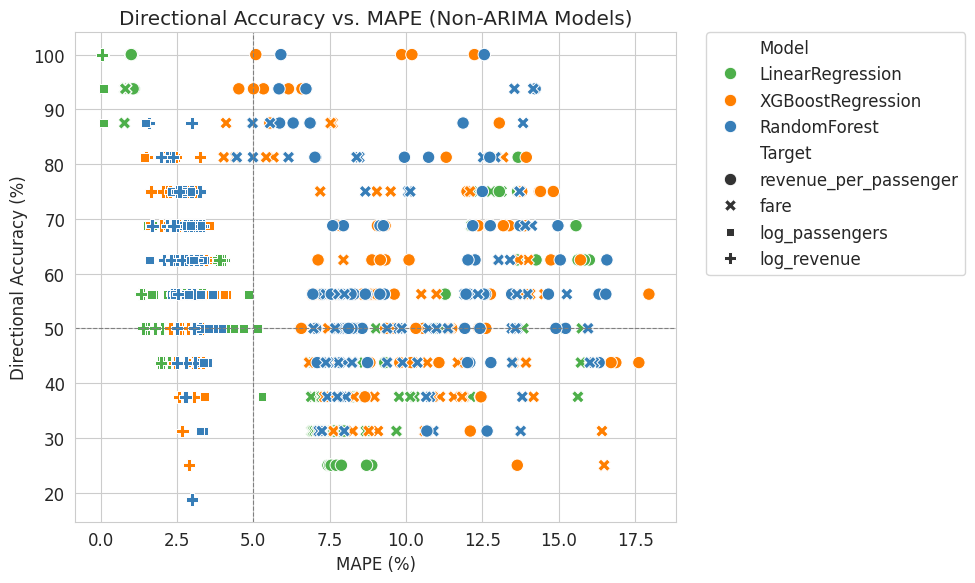

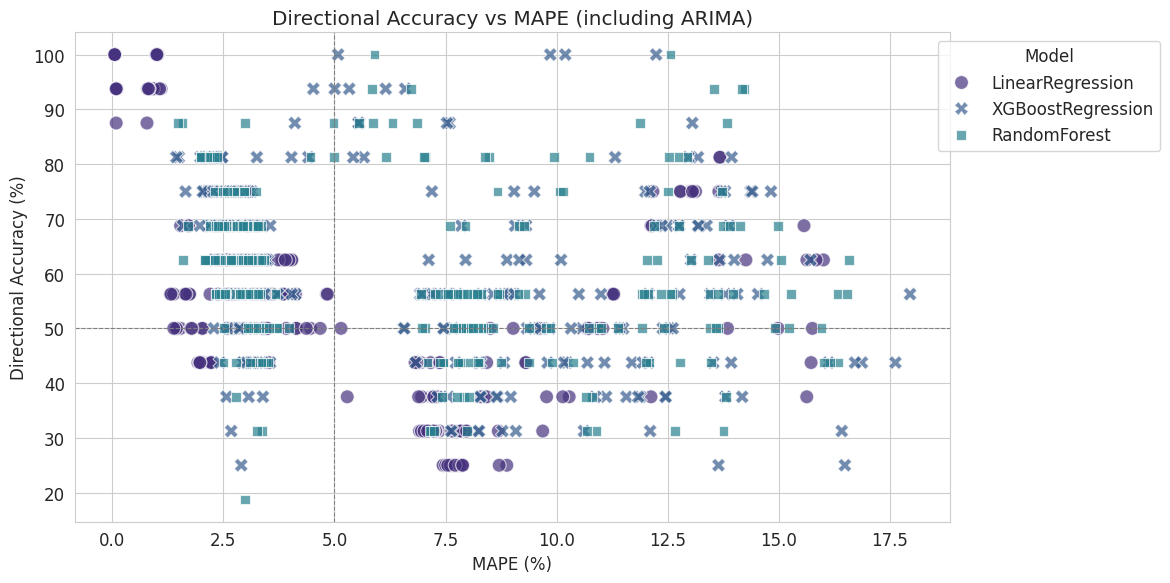

In [ ]:
# Call the functions with appropriate parameters
plot_best_metric_by_features(results_df, 'MAPE', maximize=False)
plot_best_metric_by_features(results_df, 'MAE', maximize=False)
plot_best_metric_by_features(results_df, 'R2', maximize=True)
plot_best_metric_by_features(results_df, 'Directional_Accuracy', maximize=True)
plot_best_metric_by_target(results_df, 'MAPE', maximize=False)
scatter_directional_accuracy_vs_mape(results_df, exclude_arima=False)
scatter_directional_accuracy_vs_mape(results_df, exclude_arima=True)

### Revenue Trend Forecast via Optimal Train/Test Splits

This section implements a trend forecasting model for quarterly revenue using **linear regression** over randomized train/test splits.

The function `revenue_trend_forecast_with_split()` performs the following:

- **Input**:
  - A DataFrame with a time column (e.g., `year_quarter`) and a numeric target column (e.g., `revenue`)
  - Parameters for test split ratio (`test_size`), number of split attempts (`search_states`), and metric evaluation
- **Process**:
  - Converts the time column into a numeric index (`t`) for trend modeling
  - Iteratively performs randomized train/test splits using `random_state` from 0 to `search_states`
  - Fits a `LinearRegression` model to each split
  - Computes evaluation metrics on the test set:
    - R² (coefficient of determination)
    - MAE (mean absolute error)
    - RMSE (root mean squared error)
    - MAPE (mean absolute percentage error)
    - Directional Accuracy (how often the trend direction is predicted correctly)
  - Tracks and compares all splits, selecting the one with the **highest R²** as the best

- **Output**:
  - A plot of actual vs predicted trend values across the full timeline
  - Color-coded scatter points showing training vs test set contributions
  - Final evaluation metrics printed for the R²-best split




In [ ]:
def revenue_trend_forecast_with_split(quarterly_revenue, test_size=0.2, search_states=100,
    time_col='year_quarter', target_col='revenue'):
    """
    Loops over multiple train/test splits using random_state to find the best-performing splits
    across several metrics: R², MAE, RMSE, MAPE, Directional Accuracy.
    Uses the R²-best split for the final plot and output.

    Parameters:
    - quarterly_revenue: pd.DataFrame with at least [time_col, target_col]
    - test_size: float, proportion of the dataset to include in the test split
    - search_states: int, number of random states to test (default 100)
    - time_col: str, column name for the time index
    - target_col: str, column name for revenue
    """

    df = quarterly_revenue.copy().reset_index(drop=True)
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    if df[target_col].isna().any():
        raise ValueError(f"{target_col} contains non-numeric or missing values.")

    # Convert period for plotting
    if pd.api.types.is_period_dtype(df[time_col]):
        df[time_col] = df[time_col].astype(str)  # or .dt.to_timestamp()
    df['t'] = range(len(df))  # simple time index

    X = df[['t']]
    y = df[target_col]

    best_metrics = {
        'r2': {'value': -float('inf'), 'state': None},
        'mae': {'value': float('inf'), 'state': None},
        'rmse': {'value': float('inf'), 'state': None},
        'mape': {'value': float('inf'), 'state': None},
        'directional': {'value': -float('inf'), 'state': None}
    }

    best_model_by_r2 = None
    best_split_by_r2 = {}

    for rs in range(search_states):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=rs, shuffle=True
        )
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        if len(y_test) > 1:
            actual_direction = np.sign(np.diff(y_test))
            pred_direction = np.sign(np.diff(y_pred))
            directional_accuracy = np.mean(actual_direction == pred_direction) * 100
        else:
            directional_accuracy = 0

        # Track best states by metric
        if r2 > best_metrics['r2']['value']:
            best_metrics['r2'] = {'value': r2, 'state': rs}
            best_model_by_r2 = model
            best_split_by_r2 = {
                'X_train': X_train, 'X_test': X_test,
                'y_train': y_train, 'y_test': y_test
            }

        if mae < best_metrics['mae']['value']:
            best_metrics['mae'] = {'value': mae, 'state': rs}
        if rmse < best_metrics['rmse']['value']:
            best_metrics['rmse'] = {'value': rmse, 'state': rs}
        if mape < best_metrics['mape']['value']:
            best_metrics['mape'] = {'value': mape, 'state': rs}
        if directional_accuracy > best_metrics['directional']['value']:
            best_metrics['directional'] = {'value': directional_accuracy, 'state': rs}

    # Use R²-best model for final prediction and plot
    model = best_model_by_r2
    X_train = best_split_by_r2['X_train']
    X_test = best_split_by_r2['X_test']
    y_train = best_split_by_r2['y_train']
    y_test = best_split_by_r2['y_test']

    df['revenue_trend'] = model.predict(df[['t']])
    df['set_type'] = 'other'
    df.loc[X_train.index, 'set_type'] = 'train'
    df.loc[X_test.index, 'set_type'] = 'test'

    # Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x=time_col, y=target_col, label='Actual Revenue', color='black')
    sns.lineplot(data=df, x=time_col, y='revenue_trend', label='Linear Trend', color='red', linestyle='--')

    sns.scatterplot(data=df[df['set_type'] == 'train'], x=time_col, y=target_col, color='green', label='Training Points', s=80)
    sns.scatterplot(data=df[df['set_type'] == 'test'], x=time_col, y=target_col, color='orange', label='Test Points', s=80)

    plt.title(f'Revenue Forecast (Best R² from {search_states} splits — random_state={best_metrics["r2"]["state"]})')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Final output metrics
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    if len(y_test) > 1:
        actual_direction = np.sign(np.diff(y_test))
        pred_direction = np.sign(np.diff(y_pred))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = 0

    print(f"Best random states by metric:")
    print(f"  R² (maximize):               {best_metrics['r2']['state']} → {best_metrics['r2']['value']:.4f}")
    print(f"  MAE (minimize):              {best_metrics['mae']['state']} → {best_metrics['mae']['value']:,.2f}")
    print(f"  RMSE (minimize):             {best_metrics['rmse']['state']} → {best_metrics['rmse']['value']:,.2f}")
    print(f"  MAPE (minimize):             {best_metrics['mape']['state']} → {best_metrics['mape']['value']:.2f}%")
    print(f"  Directional Accuracy (max):  {best_metrics['directional']['state']} → {best_metrics['directional']['value']:.2f}%")

    print(f"\n Test Set Evaluation (from best R² split):")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Directional Accuracy: {directional_accuracy:.2f}%")

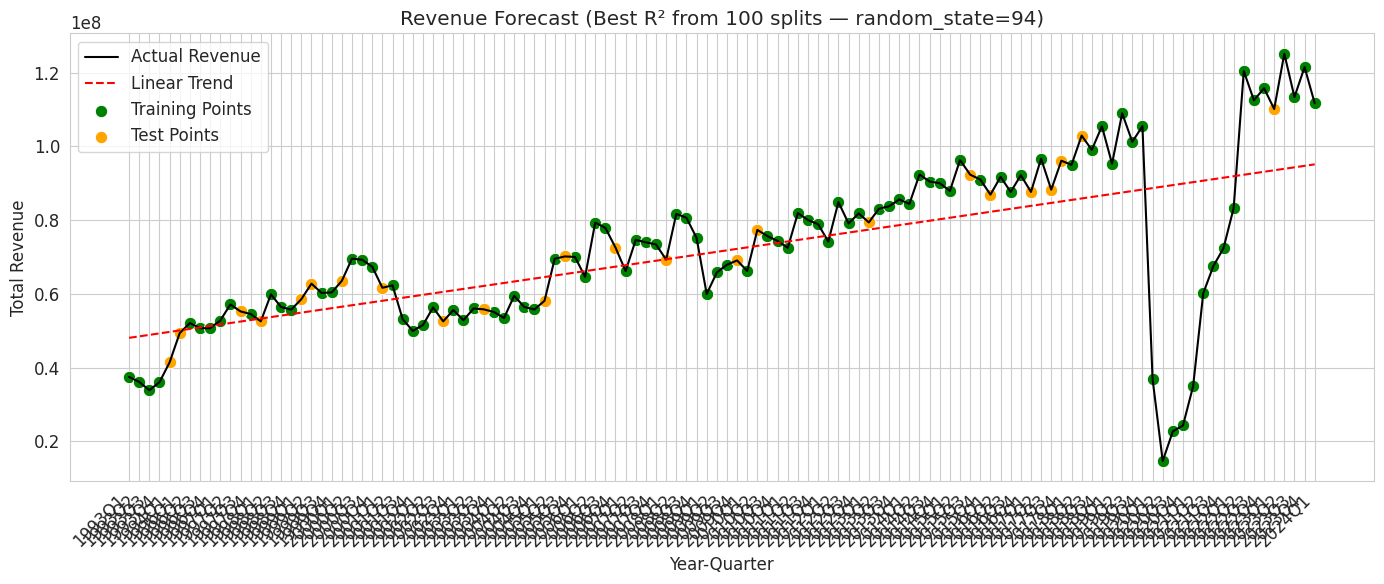

Best random states by metric:
  R² (maximize):               94 → 0.8303
  MAE (minimize):              94 → 5,915,820.67
  RMSE (minimize):             94 → 7,333,219.48
  MAPE (minimize):             38 → 7.92%
  Directional Accuracy (max):  12 → 100.00%

 Test Set Evaluation (from best R² split):
  MAE:  5,915,820.67
  RMSE: 7,333,219.48
  MAPE: 8.15%
  Directional Accuracy: 86.96%


In [ ]:
revenue_trend_forecast_with_split(
    quarterly_revenue=agg_df.reset_index()[['period', 'revenue']].rename(columns={'period': 'year_quarter'}),
    time_col='year_quarter',
    target_col='revenue'
)